# FS implementation in python

This code implements the Fisher Scoring algorithm for estimating the parameters of linear mixed effects models as described in [Demidenko 2013](https://www.wiley.com/en-us/Mixed+Models%3A+Theory+and+Applications+with+R%2C+2nd+Edition-p-9781118091579).

## Pip Installations

Pip install everything.

In [0]:
!pip install numpy
!pip install pandas
!pip install scipy
!pip install matplotlib
!pip install sparse
!pip install nibabel
!pip install nilearn


## Python Imports




We need:
 - `numpy` for matrix handling.
 - `scipy` for sparse matrix functions.
 - `pandas` for quick reading and writing of csv files.
 - `os` and `sys` for basic commandline functions
 - `time` for timing functions.
 - `matplotlib` for making displays.

In [0]:
import numpy as np
import cvxopt
import pandas as pd
import os
import time
import scipy.sparse
import scipy.sparse.linalg
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import sys
import nibabel as nib
import nilearn

## Toy Dataset

This section read ins and formats a toy dataset. The files used here were generated in `R` and with **True** values (those with postfix `True`) being those used to generate the data and **Estimated** (those with postfix `REst`) values being the estimates `R`'s `lmer` package generated from this data.

In [0]:
# Import shutil and remove old testdata
#import shutil
#shutil.rmtree('/Data')

# Make a data directory
if not os.path.isdir('/Data'):
  os.mkdir('/Data')
  
os.chdir('/Data')

# Clone small git repo containg some csv files.
if not os.path.isdir('/Data/BLMM-testdata'):
  !git clone https://github.com/TomMaullin/BLMM-testdata.git
  


### Z matrix

The below reads in Z and makes an image of Z transpose.


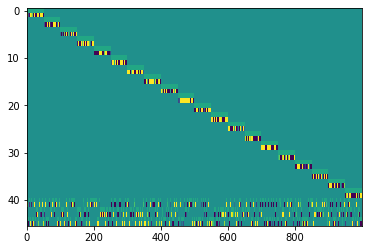

In [0]:
# Read in random effects design matrix and convert it into it's sparse format in
# cvxopt.
Z_3col=pd.read_csv('/Data/BLMM-testdata/Z_3col.csv',header=None).values#pd.read_csv('/Data/BLMM-testdata/Z_3col_1factor.csv',header=None).values#
Z = scipy.sparse.csr_matrix((Z_3col[:,2].tolist(), \
                            ((Z_3col[:,0]-1).astype(np.int64), \
                             (Z_3col[:,1]-1).astype(np.int64))))

# Create an image of Z'
imshow(Z.toarray().transpose(), \
       interpolation='nearest', vmin=-5, vmax=5, aspect='auto')

# Number of subjects
n = Z.shape[0]

#### Dealing with ill-specified intercept models

The above Random effects design matrix has multiple intercepts and is therefore of less than rank $q$; to resolve this we transform $Z$ by a matrix $c$ such that it's now has ($q-\sum_{i=1}^r\mathbb{1_{[\text{Factor i has an intercept}]}}$) orthogonal columns (where $\mathbb{1}$ is an indicator function). This is achieved in the below code by having $c$ as the unique matrix which subtracts, for each factor, the intercept for the last level of the factor away from the other levels of said factor. This may be clearer to understand in matrix format:

Example:

$$\begin{bmatrix} z_1 & 0 & 0 \\ z_2 & 0 & 0 \\ z_3 & 0 & 0 \\0 & z_4 & 0 \\ 0 & z_5 & 0 \\ 0 & z_6 & 0 \\ 0 & 0 & z_7 \\ 0 & 0 & z_8 \\ 0 & 0 & z_9 \\ \end{bmatrix} c = \begin{bmatrix} z_1 & 0 \\ z_2 & 0 \\ z_3 & 0 \\0 & z_4 \\ 0 & z_5 \\ 0 & z_6 \\ -z_7 & -z_7 \\ -z_8 & -z_8  \\ -z_9 & -z_9  \\ \end{bmatrix}$$

In this example, $c$ would be given by the matrix:

$$c = \begin{bmatrix} 1 & 0 \\ 0 & 1 \\ -1 & -1\end{bmatrix}$$

In this code I have made the assumption WLOG that the intercept for each factor, should it be included, is the first parameter listed for each factor.

UPDATE: SCRAPPED - RUINED BLOCK DIAGONAL STRUCTURE OF Z

In [0]:
#import numba

#@numba.jit
#def obtainC(nlevels, nparams, interceptIndicator):
  
  # Columns per factor
  # This array tells us how many columns each factor has in Z.
  # i.e. colsPerFactor[k]=4 means the kth factor has 4 columns
#  colsPerFactor = nlevels*nparams
  
  # List of first column of Z for each level of each factor (If an intercept has
  # been included for factor k, then it is assumed that the intercept is in the 
  # first column of each level of factor k; therefore this list contains all 
  # intercept column indices by assumption). One additional entry is included at 
  # the end which is the number of columns in z; this can be useful looping.
#  interceptCols = np.insert(np.cumsum(np.repeat(nparams, nlevels)),0,0)

  # The below array marks the first entry for each factor in interceptCols
  # i.e. interceptCols[factorChangepoints[k]] is the first intercept for
  # factor k
#  factorChangepoints = np.insert(np.cumsum(nlevels),0,0)

  # Loop through each factor
#  for k in np.arange(len(nlevels)):
  
    # If we have an intercept for this factor work out which
    # columns hold the intercepts
#    if interceptIndicator[k]==1:
      
      # Get the intercept columns for factor k
#      interceptCols_k = interceptCols[factorChangepoints[k]:factorChangepoints[k+1]]-interceptCols[factorChangepoints[k]]
      
      # Get a vector with -1 in each position for all intercept columns
#      negativeCols = np.zeros(colsPerFactor[k])
#      negativeCols[interceptCols_k] = -1
      
      # Get an identity matrix which is number of columns for factor k by number
      # of columns for factor k in size. This will become c for factor k
#      c_k = np.eye(colsPerFactor[k])
      
      # This is the index of the column we are removing from Z with this transform
#      toRemove = interceptCols_k[-1]
      
      # Place the negative Cols matrix in the row corresponding to the intercept 
      # column
#      c_k[toRemove,:] = negativeCols
#      c_k = np.delete(c_k,toRemove,axis=1)
      
#      if k == 0:
        
#        c = c_k
        
#      else:
        
#        c = scipy.linalg.block_diag(c, c_k)
      
#  imshow(c, \
#     interpolation='nearest', aspect='auto',vmax=2,vmin=-1)
#  plt.colorbar()

#  return(c)

#t1 = time.time()
#c=obtainC(nlevels, nparams, [1,1])      
#t2 = time.time()
#print(t2-t1)

#t1 = time.time()
#obtainC(nlevels, nparams, [1,1])      
#t2 = time.time()
#print(t2-t1)


#print(np.cumsum(nlevels * nparams))

#nparams = [2,2]
#nparamstmp[1] = 3

# List of columns of Z containing intercept
#interceptCols = np.insert(np.cumsum(np.repeat(nparams, nlevels)),0,0)[:-1]

# The below array marks the first entry for each factor in interceptCols
# i.e. interceptCols[factorChangepoints[k]] is the first intercept for
# factor k
#factorChangepoints = np.insert(np.cumsum(nlevels),0,0)
#print('factor change points')
#print(factorChangepoints)

# Columns per factor
# This array tells us how many columns each factor has in Z.
# i.e. colsPerFactor[k]=4 means the kth factor has 4 columns
#colsPerFactor = nlevels*nparams
#print('colsPerFactor')
#print(colsPerFactor)

#k = 0
# Intercept columns for one factor
#print(interceptCols[factorChangepoints[k]:factorChangepoints[k+1]])

#print(interceptCols)
#print(len(interceptCols))

#print(Z[:, interceptCols].toarray())

#print(np.cumsum(nlevels))

#print(nparams)
      
  

In [0]:

#imshow((Z @ scipy.sparse.csr_matrix(c)).toarray(), \
#     interpolation='nearest', aspect='auto', vmax = 2, vmin = -1)
#plt.colorbar()


In [0]:

#imshow(((Z @ scipy.sparse.csr_matrix(c)).transpose() @ (Z @ scipy.sparse.csr_matrix(c))).toarray(), \
#     interpolation='nearest', aspect='auto', vmax = 2, vmin = -1)
#plt.colorbar()

In [0]:
#imshow((Z).toarray(), \
#     interpolation='nearest', aspect='auto', vmax = 2, vmin = -1)
#plt.colorbar()

In [0]:
#imshow((Z.transpose() @ Z).toarray(), \
#     interpolation='nearest', aspect='auto')
#plt.colorbar()

#### Demean and rescale Z

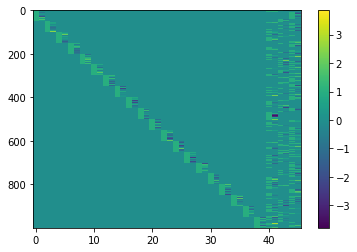

In [0]:
def demeanAndRescaleZ(Z, nparams, nlevels):
  
  # List of columns of Z containing intercept, assume if there is an intercept;
  # that it is in the first column of each level of each factor
  interceptCols = np.insert(np.cumsum(np.repeat(nparams, nlevels)),0,0)[:-1]
  
  # Make demeaned and rescaled Z
  Z_dr = Z
  
  # Loop through each column
  for i in np.arange(Z.shape[1]):
    
    # Check if column is an intercept
    if i in interceptCols:
      
      # If the array doesn't contain only zero and one
      if not np.array_equal(np.unique(Z[:,i]), np.array([0,1])):
        
        Z_dr[np.nonzero(Z_dr[:,i]),i] = (Z_dr[np.nonzero(Z_dr[:,i]),i]-np.mean(Z_dr[np.nonzero(Z_dr[:,i]),i]))/np.std(Z_dr[np.nonzero(Z_dr[:,i]),i])
                                         
    else:
      
      Z_dr[np.nonzero(Z_dr[:,i]),i] = (Z_dr[np.nonzero(Z_dr[:,i]),i]-np.mean(Z_dr[np.nonzero(Z_dr[:,i]),i]))/np.std(Z_dr[np.nonzero(Z_dr[:,i]),i])
        
  return(Z_dr)
nlevels = np.array([20,3])#])#
nparams = np.array([2,2])#])#
Z_dr = demeanAndRescaleZ(Z.toarray(), nparams, nlevels)

imshow(Z_dr, \
     interpolation='nearest', aspect='auto')
plt.colorbar()


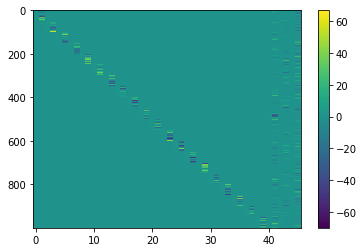

In [0]:
imshow(Z.toarray(), \
     interpolation='nearest', aspect='auto')
plt.colorbar()

#Z_orig = Z.toarray()
#Z = scipy.sparse.csr_matrix(Z_dr)

### Estimated Random Effects matrix

The below reads in the Random effects variance predicted by `R`'s `lmer`.

In [0]:
# Read in estimated variance
RFXVar_REst = pd.read_csv('/Data/BLMM-testdata/estd_rfxvar.csv',header=None).values#pd.read_csv('/Data/BLMM-testdata/estd_rfxvar_1factor.csv',header=None).values#

### Y vector

The response vector is read in here:

In [0]:
Y=pd.read_csv('/Data/BLMM-testdata/Y.csv',header=None).values#pd.read_csv('/Data/BLMM-testdata/Y_1factor.csv',header=None).values#

### X matrix

The fixed effects design matrix is read in here. It consists of an intercept and two random (Gaussian) columns.


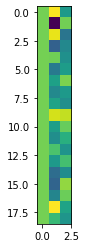

In [0]:
X=pd.read_csv('/Data/BLMM-testdata/X.csv',header=None).values#pd.read_csv('/Data/BLMM-testdata/X_1factor.csv',header=None).values#

# Image of the first 20 rows of X
imshow(X[1:20,:])

### Number of Levels and Parameters

The number of levels is given by a vector with one entry for each grouping factor. e.g. nlevels=[10,2] means there are 10 levels for factor 1 and 2 levels for factor 2. 

The number of parameters is given by a vector with one entry for each grouping factor. e.g. nparams=[3,4] means there are 3 variables for factor 1 and 4 variables for factor 2.

In [0]:
nlevels = np.array([20,3])#])#
nparams = np.array([2,2])#])#

### True b values

The true recorded values of the random effects b vector in this example.

In [0]:
b_True=pd.read_csv('/Data/BLMM-testdata/true_b.csv',header=None).values#pd.read_csv('/Data/BLMM-testdata/true_b_1factor.csv',header=None).values#

### True beta values

The true fixed effects parameters used to generate this example.

In [0]:
beta_True=pd.read_csv('/Data/BLMM-testdata/true_beta.csv',header=None).values#pd.read_csv('/Data/BLMM-testdata/true_beta_1factor.csv',header=None).values#

### Product Matrices

All products of matrices are calculated beforehand as it is both more computationally efficient and also similar to the setting we are interested in. 

In [0]:
# Z transpose Z
print(Z.shape)
ZtZ = np.matmul(Z.toarray().transpose(),Z.toarray()) # This works for products involving sparse
# Sparse 
# ZtZ = Z.transpose() * Z

# Z transpose X
XtZ = np.matmul(X.transpose(),Z.toarray())

# X transpose Z
ZtX = np.matmul(Z.toarray().transpose(),X)

# ZtY
ZtY = np.matmul(Z.toarray().transpose(),Y)

# YtZ
YtZ = np.matmul(Y.transpose(),Z.toarray())

# XtX
XtX = np.matmul(X.transpose(),X)

# XtY
XtY = np.matmul(X.transpose(),Y)

# YtX
YtX = np.matmul(Y.transpose(),X)

# YtX
YtY = np.matmul(Y.transpose(),Y)

(1000, 46)


## Helper Functions

This section contains miscellaneous functions used to help the `FS` function including functions to work out the duplication matrix.


###Matrix to Vector function

This function takes in a matrix and vectorizes it (i.e. transforms it to a vector of each of the columns of the matrix stacked on top of one another). Example:

$$\begin{bmatrix} a & b & c \\ d & e & f \\ g & h & i \\\end{bmatrix} \rightarrow \begin{bmatrix} a \\ d \\ g \\ b \\ e \\ h \\ c \\ f \\ i \end{bmatrix}$$.

In [0]:
def mat2vec(matrix):
  
  #Return vectorised matrix
  return(matrix.transpose().reshape(matrix.shape[0]*matrix.shape[1],1))

# Example:
matrix = np.random.randn(3,3)
print(matrix)
print(mat2vec(matrix))

[[-0.24743997 -0.44658289  1.14229487]
 [ 0.16295752  0.13361416  0.4584038 ]
 [-0.35327204  0.14878323 -2.72201285]]
[[-0.24743997]
 [ 0.16295752]
 [-0.35327204]
 [-0.44658289]
 [ 0.13361416]
 [ 0.14878323]
 [ 1.14229487]
 [ 0.4584038 ]
 [-2.72201285]]


###Matrix to Vector function

This function takes in a (symmetric, square) matrix and half-vectorizes it (i.e. transforms it to a vector of each of the columns of the matrix, below and including the diagonal, stacked on top of one another). Example:

$$\begin{bmatrix} a & b & c \\ b & d & e \\ c & e & f \\\end{bmatrix} \rightarrow \begin{bmatrix} a \\ b \\ c \\ d \\ e \\ f \end{bmatrix}$$.

In [0]:
def mat2vech(matrix):
  
  # Get lower triangular indices
  rowinds, colinds = np.tril_indices(matrix.shape[0]) #Try mat.transpose()[trilu]?
  
  # They're in the wrong order so we need to order them
  # To do this we first hash them
  indhash = colinds*matrix.shape[0]+rowinds
  
  # Sort permutation
  perm=np.argsort(indhash)
  
  # Return vectorised half-matrix
  return(np.array([matrix[rowinds[perm],colinds[perm]]]).transpose())

# Example:
matrix = np.random.randn(3,3)
print(matrix*matrix.transpose())
print(mat2vech(matrix*matrix.transpose()))

#print(vech2mat(invDupMat(3) @ mat2vec(matrix*matrix.transpose())))

[[ 5.68884519  0.05285794  1.24727827]
 [ 0.05285794  0.88935512 -0.06957667]
 [ 1.24727827 -0.06957667  0.044964  ]]
[[ 5.68884519]
 [ 0.05285794]
 [ 1.24727827]
 [ 0.88935512]
 [-0.06957667]
 [ 0.044964  ]]


In [0]:
def vec2mat(vec):
  
  # Return matrix
  return(vec.reshape(np.int64(np.sqrt(vec.shape[0])),np.int64(np.sqrt(vec.shape[0]))).transpose())

# Example
#vec = np.array([[1,2,3,4]]).transpose()
#mat = vec2mat(vec)
#print(vec)
#print(mat)

In [0]:
def vech2mat(vech):
  
  # dimension of matrix
  n = np.int64((-1+np.sqrt(1+8*vech.shape[0]))/2)
  matrix = np.zeros((n,n))
  
  # Get lower triangular indices
  rowinds, colinds = np.tril_indices(matrix.shape[0])
  
  # They're in the wrong order so we need to order them
  # To do this we first hash them
  indhash = colinds*matrix.shape[0]+rowinds
  
  # Sort permutation
  perm=np.argsort(indhash)
  
  # Assign values to lower half
  matrix[rowinds[perm],colinds[perm]] = vech.reshape(vech.shape[0])
  
  # Assign values to upper half
  matrix[colinds[perm],rowinds[perm]] = vech.reshape(vech.shape[0])
  
  # Return vectorised half-matrix
  return(matrix)

# Example:
#vech = np.array([[1],[2],[3],[4],[5],[6],[7],[8],[9],[10]])
#matrix = vech2mat(vech)
#print(vech)
#print(matrix)

In [0]:
def vec2vech(vec):
  
  # Return vech
  return(mat2vech(vec2mat(vec)))

# Example
#vec = np.array([[1],[2],[3],[2],[4],[5],[3],[5],[6]])
#vech = vec2vech(vec)

#print(vec)
#print(vech)

In [0]:
def vech2vec(vech):
  
  # Return vec
  return(mat2vec(vech2mat(vech)))

# Example
#vech = np.array([[1],[2],[3],[4],[5],[6],[7],[8],[9],[10]])
#vec = vech2vec(vech)

#print(vech)
#print(vec)

In [0]:
def dupMat(n):
  
  # Make vech of 1:(n(n+1)/2)
  vech = np.arange(n*(n+1)/2)
  
  # Convert to vec
  vec = vech2vec(vech)
  
  # Make D (sparse one hot encoded vec)
  D = scipy.sparse.csr_matrix((np.ones(n**2),(np.arange(n**2),np.int64(vec).reshape(vec.shape[0]))))
  
  return(D)

# Example
#print(dupMat(3))

In [0]:
def invDupMat(n):
  
  
  # Make vech of 1:(n(n+1)/2)
  vech = np.arange(n*(n+1)/2)
  
  # Convert to vec
  vec = np.int64(vech2vec(vech))
  vec = vec.reshape(vec.shape[0])
  
  # Work out frequency of each entry
  freq = 1/np.bincount(vec)
  
  # Work out duplication matrix
  D = scipy.sparse.csr_matrix((freq[vec],(vec,np.arange(n**2))))
  
  return(D)

import scipy.sparse
# Example
print(invDupMat(3))

  (0, 0)	1.0
  (1, 1)	0.5
  (1, 3)	0.5
  (2, 2)	0.5
  (2, 6)	0.5
  (3, 4)	1.0
  (4, 5)	0.5
  (4, 7)	0.5
  (5, 8)	1.0


#### Commutation matrix

----
This function takes as input;

----
 - $a$: A postive integer.
 - $b$: A postive integer.

----
And returns:

----
 - $K$: The commutation matrix (in sparse format) which maps $vec(A)$ to $vec(A')$ for an arbitrary matrix $A$ of dimensions $(a \times b)$, i.e. $K$ is the unique matrix which satisfies, for all $A$;

 $$K vec(A) = vec(A')$$

In [0]:
#def comMat2D(a, b):
#
#  # Example matrix with unique elements
#  m = np.arange(a*b).reshape(a,b)
#
#  # Vec(m) and Vec(m')
#  vecm = mat2vec(m)
#  vecmt = mat2vec(m.transpose())
#
#  # Work out mapping between them.
#  K=scipy.sparse.csr_matrix((vecm.transpose()==vecmt).astype(int))
#
#  return(K)

def comMat2D(a, b):

  # Get row indices
  row  = np.arange(a*b)

  # Get column indices
  col  = row.reshape((a, b), order='F').ravel()

  # Ones to put in the matrix
  data = np.ones(a*b, dtype=np.int8)

  # Sparse it
  K = scipy.sparse.csr_matrix((data, (row, col)), shape=(a*b, a*b))
  
  # Return K
  return(K)

The below code tests and times ``comMat2D``.

In [0]:
# Random dimensions
a = np.random.randint(100,500)
b = np.random.randint(100,500)

# Get K
t1 = time.time()
K = comMat2D(a,b)
t2 = time.time()
print(t2-t1)

# Random A
A = np.random.randn(a,b)

print(np.allclose(mat2vec(A.transpose()),K @ mat2vec(A)))

0.0019652843475341797
True


#### Permutation of I kron K kron I

The below function takes as inputs:
 
 ----
 - $k_1$: A positive integer.
 - $k_2$: A positive integer.
 - $n_1$: A positive integer.
 - $n_2$: A positive integer.

 
 ----

And returns the permutation vector $p$ such that for any matrix $A$ of appropriate dimensions.

$(I_{k_1} \otimes K_{n_1,k_2} \otimes I_{n_2})A=A_p$

Where $A_p$ is the matrix $A$ with $p$ applied to it's rows and $K_{n_1,k_2}$ is the $(n_1,k_2)$, commutation matrix.

In [0]:
def permOfIkKkI(k1,k2,n1,n2):

  # First we need the permutation represented by matrix K in vector format
  permP = np.arange(n1*k2).reshape((n1, k2), order='F').ravel()

  # Now we work out the permutation obtained by the first kronecker product (i.e. I kron K)
  permKron1 = np.repeat(np.arange(k1),n1*k2)*n1*k2+np.tile(permP,k1)

  # Now we work out the final permutation by appplying the second kronecker product (i.e. I kron K kron I)
  p = np.repeat(permKron1,n2)*n2+np.tile(np.arange(n2),n1*k1*k2)

  # Return the permutation
  return(p)

The below code tests and times the above function.

In [0]:
m = np.random.randint(1,10)
n1=np.random.randint(1,10)
n2=np.random.randint(1,10)
k1=np.random.randint(1,10)
k2=np.random.randint(1,10)

print('Example Shapes:')
print('m: ', m)
print('k1, k2: ', k1, k2)
print('n1, n2: ', n1, n2)

testMat = np.random.randn(k1*k2*n1*n2,m)

t1 = time.time()
K = comMat2D(n1, k2).toarray()

print(K.shape)
IPI = np.kron(np.kron(np.eye(k1), K), np.eye(n2))
print(IPI)
print(IPI.shape)
print(testMat.shape)
result1 = IPI @ testMat
t2 = time.time()
print(t2-t1)

t1 = time.time()
perm = permOfIkKkI(k1,k2,n1,n2)
result2 = testMat[perm,:]
t2 = time.time()
print(t2-t1)

print(np.allclose(result1,result2))
print(K.shape)


Example Shapes:
m:  9
k1, k2:  7 3
n1, n2:  7 3
(21, 21)
[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
(441, 441)
(441, 9)
0.0072536468505859375
0.0004546642303466797
True
(21, 21)


#### Convert blocked matrix to stacked matrix

----
This function takes as inputs:

----
 - `A`: A 2D matrix of size $(m_1 \times m_2)$.
 - `pA`: The size of the block partitions of $A$, e.g. if $A_{i,j}$ is of dimension $(n_1 \times n_2)$ then ``pA=[n1, n2]``.

----
And returns as output:

----
 - `As`: The matrix $A$ reshaped to have all blocks $A_{i,j}$ on top of one another. I.e. the below mapping has been performed:

$$A = \begin{bmatrix} A_{1,1} & A_{1,2} & ... & A_{1,l_2} \\ A_{2,1} & A_{2,2} & ... & A_{2,l_2} \\ \vdots \\ A_{l_1,1} & A_{l_1,2} & ... & A_{l_1,l_2} \end{bmatrix} \rightarrow A_s = \begin{bmatrix} A_{1,1} \\ A_{1,2} \\ \vdots \\ A_{1,l_2} \\ A_{2,1} \\ \vdots \\ A_{l_1,l_2} \end{bmatrix}$$

In [0]:
def block2stacked2D(A, pA):

  # Work out shape of A
  m1 = A.shape[0]
  m2 = A.shape[1]

  # Work out shape of As
  n1 = pA[0]
  n2 = pA[1]
  
  # Change A to stacked form
  As = A.reshape((m1//n1,n1,m2//n2,n2)).transpose(0,2,1,3).reshape(m1*m2//n2,n2)

  return(As)

Below is a demonstration/test of this function:

In [0]:
# Random block sizes
n1 = np.random.randint(2,6)
n2 = np.random.randint(2,6)
pA = np.array([n1,n2])

# Random number of blocks
l1 = np.random.randint(1,3)
l2 = np.random.randint(1,3)

# Shape of A
m1 = l1*n1
m2 = l2*n2

# Create A
A = np.random.randn(m1,m2)
print(n1,n2,m1,m2)
print(A.shape)
# Print A
print(A)
print(block2stacked2D(A,pA))

3 4 3 4
(3, 4)
[[ 2.21542127 -0.52650135 -0.03271491 -0.72991395]
 [ 0.50035739  1.49795226 -0.60384647  0.94698649]
 [ 1.83891815  1.03529662 -0.21601111  0.30875488]]
[[ 2.21542127 -0.52650135 -0.03271491 -0.72991395]
 [ 0.50035739  1.49795226 -0.60384647  0.94698649]
 [ 1.83891815  1.03529662 -0.21601111  0.30875488]]


#### Convert blocked matrix to a stacked vector matrix

The below function takes the following inputs:

----
 - `mat`: An abritary matrix whose dimensions are multiples of `p[0]` and `p[1]` respectively.
 - `p`. The size of the chunks we are partitioning `mat` into.

----
And gives the following outputs:

----
 - `vecb`: A matrix composed of each block of `mat`, converted to row vectors, stacked on top of one another. I.e. for an arbitrary matrix $A$ of appropriate dimensions, $vecb(A)$ is the result of the mapping;

 
$$A = \begin{bmatrix} A_{1,1} & A_{1,2} & ... & A_{1,l_2} \\ A_{2,1} & A_{2,2} & ... & A_{2,l_2} \\ \vdots \\ A_{l_1,1} & A_{l_1,2} & ... & A_{l_1,l_2} \end{bmatrix} \rightarrow \tilde{a} = \begin{bmatrix} vec'(A_{1,1}) \\ vec'(A_{1,2}) \\ \vdots \\ vec'(A_{1,l_2}) \\ vec'(A_{2,1}) \\ \vdots \\ vec'(A_{l_1,l_2}) \end{bmatrix}$$

Where $A_{i,j}$ has dimensions $($ `p[0]` $\times$ `p[1]` $)$ for all $i$ and $j$.

In [0]:
# Block vec with row-wise chunks of size n
def mat2vecb2D(mat,p):

  # Change to stacked block format, if necessary
  if p[1]!=mat.shape[1]:
    mat = block2stacked2D(mat,p)

  # Get height of block.
  n = p[0]
  
  # Work out shape of matrix.
  m = mat.shape[0]
  k = mat.shape[1]

  # Convert to stacked vector format
  vecb = mat.reshape(m//n, n, k).transpose((1, 0, 2)).reshape(n, m*k//n).transpose().reshape(m//n,n*k)

  #Return vecb
  return(vecb)

The below code tests and outputs the above function.

In [0]:
# Random block sizes
n1 = np.random.randint(2,4)
n2 = np.random.randint(2,4)

# Blocksize
p = np.array([n1,n2])

# Random number of blocks
l1 = np.random.randint(2,4)
l2 = np.random.randint(2,4)

# Resultant matrix sizes
m1 = l1*n1
m2 = l2*n2

# Random matrices
A = np.random.randn(m1,m2)

print(A)
print(mat2vecb2D(A,p))

[[-2.59471889 -0.16395385 -2.96685959  0.38299481  1.41426412  0.77254921]
 [-0.22682522  1.19420201  1.4842787  -0.26310432  0.09563809  2.41971959]
 [-0.12669333 -0.42498082 -1.49403867  0.18342952 -0.1933991  -1.22022735]
 [-0.18524884 -0.99999577 -0.64308299  0.66144199 -1.30490375  1.63828227]
 [ 1.12973749 -1.24105313 -0.63562492 -0.53397306 -0.28808039 -0.23097332]
 [-0.1040141  -0.39748972 -0.27735959 -1.20313122 -1.94984221 -0.1960168 ]]
[[-2.59471889 -0.22682522 -0.16395385  1.19420201]
 [-2.96685959  1.4842787   0.38299481 -0.26310432]
 [ 1.41426412  0.09563809  0.77254921  2.41971959]
 [-0.12669333 -0.18524884 -0.42498082 -0.99999577]
 [-1.49403867 -0.64308299  0.18342952  0.66144199]
 [-0.1933991  -1.30490375 -1.22022735  1.63828227]
 [ 1.12973749 -0.1040141  -1.24105313 -0.39748972]
 [-0.63562492 -0.27735959 -0.53397306 -1.20313122]
 [-0.28808039 -1.94984221 -0.23097332 -0.1960168 ]]


#### Sum of Aij multiplied by Bij transpose

This function takes in the following inputs:

----
 - A: A 2D matrix of dimension $(m_1 \times m_2)$.
 - B: A 2D matrix of dimension $(m_1' \times m_2)$.
 - pA: The size of the block partitions of $A$, e.g. if $A_{i,j}$ is of dimension $(n_1 \times n_2)$ then ``pA=[n1, n2]``.
 - pB: The size of the block partitions of $B$, e.g. if $B_{i,j}$ is of dimension $(n_1' \times n_2)$ then ``pB=[n1', n2]``.

----
And gives the following output:

----
 - S: The sum of the partitions of $A$ multiplied by the transpose of the partitions of $B$; i.e. 
 
 $$\sum_{j=1}^{l_1}\sum_{i=1}^{l_2} A_{i,j}B_{i,j}'$$
  
  where $l_1:=\frac{m_1}{n_1}=\frac{m_1'}{n_1'}$ and $l_2:=\frac{m_2}{n_2}$.

In [0]:
def sumAijBijt2D(A, B, pA, pB):
  
  # Work out second (the common) dimension of the reshaped A and B
  nA = pA[0]
  nB = pB[0]

  # Work out the first (the common) dimension of reshaped A and B
  mA = A.shape[0]*A.shape[1]//nA
  mB = B.shape[0]*B.shape[1]//nB

  # Check mA equals mB
  if mA != mB:
    raise Exception('Matrix dimensions incompatible.')

  # Convert both matrices to stacked block format.
  A = block2stacked2D(A,pA)
  B = block2stacked2D(B,pB)

  # Work out the sum
  S = A.transpose().reshape((mA,nA)).transpose() @ B.transpose().reshape((mB,nB))

  # Return result
  return(S)

Below is a test of the function to check it is outputting as expected. It is also timed.

In [0]:
# Random number of blocks
l1 = np.random.randint(1,3000)
l2 = np.random.randint(1,3000)

# Random blocksizes (the second dimension must be the same for both)
n1 = np.random.randint(1,5)
n1prime = np.random.randint(1,5)
n2 = np.random.randint(1,5)

# Save block sizes
pA = np.array([n1,n2])
pB = np.array([n1prime,n2])

m1 = n1*l1
m1prime = n1prime*l1
m2 = n2*l2

k=100
l1 = m1//n1
l2 = m2//n2

# Create A
A = np.random.randn(m1,m2)
B = np.random.randn(m1prime,m2)

# Calculation by summing
t1 = time.time()

# Initiate empty sum
sumAB = np.zeros((n1,n1prime))
for i in np.arange(m1//n1):
  
  for j in np.arange(m2//n2):

    # Work out the row-wise chunks
    Aij = A[n1*i:n1*(i+1),n2*j:n2*(j+1)]
    Bij = B[n1prime*i:n1prime*(i+1),n2*j:n2*(j+1)]

    # Perform the summation
    sumAB = sumAB + Aij @ Bij.transpose()


t2 = time.time()
print('Time (Summing):', t2-t1)

t1 = time.time()
sumAB2 = sumAijBijt2D(A, B, pA, pB)
t2=time.time()
print('Time (Function):', t2-t1)

print(np.allclose(sumAB,sumAB2))

Time (Summing): 6.279120683670044
Time (Function): 0.17411351203918457
True


#### Sum of Aij kron Bij

This function takes in the following inputs:

----
 - `A`: A 2D matrix of dimension $(m_1 \times m_2)$.
 - `B`: A 2D matrix of dimension $(m_1 \times m_2)$.
 - `p`: The size of the block partitions of $A$ and $B$, e.g. if $A_{i,j}$ and$B_{i,j}$ are of dimension $(n_1 \times n_2)$ then ``pA=[n1, n2]``.
 - `perm` (optional): The permutation vector representing the matrix kronecker product $I_{n_2} \otimes K_{n_2,n_1} \otimes I_{n_1}$.

----

And gives the following output:

----

 - S: The sum of the partitions of $A$ multiplied by the transpose of the partitions of $B$; i.e. 
 
 $$\sum_{j=1}^{l_1}\sum_{i=1}^{l_2} A_{i,j} \otimes B_{i,j}$$
  
  where $l_1:=\frac{m_1}{n_1}$ and $l_2:=\frac{m_2}{n_2}$.

- `perm`: The permutation (same as input) used for calculation (useful for later computation).

In [0]:
def sumAijKronBij2D(A, B, p, perm=None):

  # Check dim A and B and pA and pB all same
  n1 = p[0]
  n2 = p[1]

  # This matrix only needs be calculated once
  if perm is None:
    perm = permOfIkKkI(n2,n1,n2,n1) 

  # Convert to vecb format
  atilde = mat2vecb2D(A,p)
  btilde = mat2vecb2D(B,p)

  # Multiply and convert to vector
  vecba = mat2vec(btilde.transpose() @ atilde)

  # Permute
  S_noreshape = vecba[perm,:] 

  # Reshape to correct shape
  S = S_noreshape.reshape(n2**2,n1**2).transpose()

  return(S,perm)

The below code tests and times the above function.

In [0]:
# Random block sizes
n1 = np.random.randint(2,10)
n2 = np.random.randint(2,10)

# Blocksize
p = np.array([n1,n2])

# Random number of blocks
l1 = np.random.randint(2,30)
l2 = np.random.randint(2,30)

# Resultant matrix sizes
m1 = l1*n1
m2 = l2*n2

# Random matrices
A = np.random.randn(m1,m2)
B = np.random.randn(m1,m2)

# Sum version
t1 = time.time()

runningSum = np.zeros((n1**2,n2**2))
# LHS calculation
t1 = time.time()
for i in np.arange(l1):
  for j in np.arange(l2):

    Aij = A[n1*i:n1*(i+1),n2*j:n2*(j+1)]
    Bij = B[n1*i:n1*(i+1),n2*j:n2*(j+1)]

    runningSum = runningSum + np.kron(Aij, Bij)

t2 = time.time()
print('Time (summing): ', t2-t1)

# Now with function
t1 = time.time()
S, perm = sumAijKronBij2D(A, B, p)
t2 = time.time()

print('Time (function): ', t2-t1)
print(np.allclose(S,runningSum))

t1 = time.time()
S, _ = sumAijKronBij2D(A, B, p, perm)
t2 = time.time()

print('Time (function, with perm): ', t2-t1)

print(np.allclose(S,runningSum))
#print(S)
#print(runningSum)

Time (summing):  0.03720569610595703
Time (function):  0.00376129150390625
True
Time (function, with perm):  0.0008482933044433594
True


In [0]:
def blockInverse(matrix, blockSize, numBlocks):

  invMatrix = scipy.sparse.csr_matrix((np.array([]), (np.array([]),np.array([]))),shape=matrix.shape)
  
  # For each level, invert the corresponding block on the diagonal
  for i in range(numBlocks):
    
    # The block is nparams by nparams
    blockInds = np.ix_(np.arange(i*blockSize,(i+1)*blockSize),np.arange(i*blockSize,(i+1)*blockSize))
    
    # Get the block
    block = matrix[blockInds]
    
    # Replace it with it's inverse
    invMatrix[blockInds]=scipy.sparse.linalg.inv(block)
    
  return(invMatrix)

# Example - need to have loaded in data first

# Get ZtZ just for the first grouping factor
firstFactorIndices = np.ix_(np.arange(nlevels[0]*nparams[0]),np.arange(nlevels[0]*nparams[0]))
ZtZ_f1 = ZtZ[firstFactorIndices]

# Compute the block inverse for ZtZ_f1
#t1 = time.time()
#ZtZ_f1_inv = blockInverse(matrix=ZtZ_f1, blockSize=nparams[0], numBlocks=nlevels[0])
#t2 = time.time()
#blockInverse_time = t2-t1

# Compare it to the inverse scipy would calculate
#t1 = time.time()
#ZtZ_f1_inv_sp = scipy.sparse.linalg.inv(ZtZ_f1)
#t2 = time.time()
#scipyInverse_time = t2-t1

#print(blockInverse_time)
#print(scipyInverse_time)


In [0]:
def recursiveInverse(M, nparams, nlevels):
  
  # Check if we have a matrix we can partition into more than 1 block
  if len(nparams) > 1:
  
    # Work out qc
    qc = nparams[-1]*nlevels[-1]
    # Make q
    q = M.shape[0]

    # Get A, B and C where M=[[A,B],[B',C]]
    # A
    A_inds = np.ix_(np.arange(0,(q-qc)),np.arange(0,(q-qc)))
    A = M[A_inds]

    # B
    B_inds = np.ix_(np.arange(0,(q-qc)),np.arange((q-qc),q))
    B = M[B_inds].toarray() # B is dense

    # C
    C_inds = np.ix_(np.arange((q-qc),q),np.arange((q-qc),q))
    C = M[C_inds].toarray() # C is small and now only involved in dense mutliplys

    # Recursive inverse A
    if nparams[:-1].shape[0] > 1:

      Ainv = recursiveInverse(A, nparams[:-1], nlevels[:-1]).toarray()

    else:

      #Ainv = blockInverse(A, nparams[0], nlevels[0]) - much slower
      Ainv = scipy.sparse.linalg.inv(scipy.sparse.csc_matrix(A)).toarray()

    # Schur complement
    S = C-np.matmul(np.matmul(B.transpose(),Ainv),B)
    Sinv = np.linalg.inv(S)

    # Top Left Hand Side of inverse
    TLHS = Ainv + np.matmul(np.matmul(np.matmul(np.matmul(Ainv,B),Sinv),B.transpose()),Ainv)


    # Top Right Hand Side of inverse
    TRHS = -np.matmul(np.matmul(Ainv,B),Sinv)


    # Bottom Right Hand Side of inverse
    BRHS = Sinv

    # Join together
    top = np.hstack((TLHS,TRHS))
    bottom = np.hstack((TRHS.transpose(), BRHS))

    # Make Minv
    Minv = np.vstack((top, bottom))
    
  else:
    
    # If we have only one block; invert it
    Minv = scipy.sparse.linalg.inv(scipy.sparse.csc_matrix(M)).toarray() 
  
  return(Minv)

# Example
t1 = time.time()
ZtZinv_rec = recursiveInverse(scipy.sparse.csc_matrix(ZtZ), nparams, nlevels)
t2 = time.time()
inv_rec_time = t2-t1

t1 = time.time()
ZtZinv_sp = scipy.sparse.linalg.inv(scipy.sparse.csc_matrix(ZtZ))
t2 = time.time()
inv_sp_time = t2-t1

t1 = time.time()
ZtZinv_np = np.linalg.inv(ZtZ)
t2 = time.time()
inv_np_time = t2-t1


print('Distance (norm) from identity (scipy)')
print(np.linalg.norm(np.matmul(ZtZinv_sp.toarray(),ZtZ)-np.eye(ZtZ.shape[0])))
print('Distance (norm) from identity (numpy)')
print(np.linalg.norm(np.matmul(ZtZinv_np,ZtZ)-np.eye(ZtZ.shape[0])))
print('Distance (norm) from identity (rec)')
print(np.linalg.norm(np.matmul(ZtZinv_rec,ZtZ)-np.eye(ZtZ.shape[0])))

print(inv_sp_time)
print(inv_np_time)
print(inv_rec_time)


Distance (norm) from identity (scipy)
289.8902619901572
Distance (norm) from identity (numpy)
1955.403906774292
Distance (norm) from identity (rec)
381.4130003726553
0.024462223052978516
0.0003294944763183594
0.03153562545776367


#### Force symmetric

The below function takes in a matrix $X$ and returns a symmetric matrix $X_s$ given by:

$$X_s = (X+X^T)/2$$

The effect of this is that if $X$ is expected to be symmetric but is not due to computational error, any antisymmetric errors will be resolved/reduced.

In [0]:
import numba
@numba.jit
def forceSym(x):
  
  # Force it to be symmetric
  return((x+x.transpose())/2)

#print(ZtZ-forceSym(ZtZ))

t1 = time.time()
ZtZ = forceSym(forceSym(ZtZ))
print(time.time()-t1)

t1 = time.time()
ZtZ = forceSym(forceSym(ZtZ))
print(time.time()-t1)

0.48226308822631836
6.67572021484375e-05


### Sum of square residuals

The function below calculates the sum of the square residuals, $e^Te$, using the below formula:

$$e^Te = (Y-X\beta)^T(Y-X\beta)$$ 
$$=Y^TY - 2Y^TX\beta + \beta^T X^TX \beta$$


----

This function takes the following inputs:

----

 - `YtX`: $Y$ transpose multiplied by $X$ ($Y^TX$ in the above notation).
 - `YtY`: $Y$ transpose multiplied by $Y$ ($Y^TY$ in the above notation).
 - `XtX`: $X$ transpose multiplied by $X$ ($X^TX$ in the above notation).
 - `beta`: An estimate of the parameter vector ($\beta$ in the above notation).
 
----

It returns as outputs:

----


 - `ete`: The sum of square residuals ($e^Te$ in the above notation).

In [0]:
def ssr(YtX, YtY, XtX, beta):
  
  # Return the sum of squared residuals
  return(YtY - 2*YtX @ beta + beta.transpose() @ XtX @ beta)

t1 = time.time()
ete = ssr(YtX, YtY, XtX, np.array([[1],[2],[3]]))
t2 = time.time()
print(t2-t1)


0.00021457672119140625


#### Get Factor Indices

This function gives the indices of the columns of the $Z$ matrix which correspond to factor $k$ level $j$. 


----

This function takes the following inputs:

----

 - `k`: The grouping factor we need the columns of.
 - `nlevels`: A vector containing the number of levels for each factor, e.g. `nlevels=[3,4]` would mean the first factor has 3 levels and the second factor has 4 levels.
 - `nparams`: A vector containing the number of parameters for each factor, e.g. `nlevels=[2,1]` would mean the first factor has 2 parameters and the second factor has 1 parameter.
 
----

It returns as outputs:

----

- `Ik`: The indices of the columns of $Z$ corresponding to factor $k$.

In [0]:
# k is zero indexed
def fac_indices(k, nlevels, nparams):
  
  # Get indices for all factors
  allInds = np.insert(np.cumsum(nlevels*nparams),0,0)

  # Work out the first index
  start = allInds[k]

  # Work out the last index
  end = allInds[k+1]

  return(np.arange(start,end))

t1 = time.time()
print(fac_indices(0, nlevels, nparams))
t2 = time.time()

print(t2-t1)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
0.0007023811340332031


#### Get Factor/Level Indices

This function gives the indices of the columns of the $Z$ matrix which correspond to factor $k$ level $j$. 


----

This function takes the following inputs:

----

 - `k`: The grouping factor we need the columns of.
 - `j`: The level of the grouping factor $k$ which we are interested in.
 - `nlevels`: A vector containing the number of levels for each factor, e.g. `nlevels=[3,4]` would mean the first factor has 3 levels and the second factor has 4 levels.
 - `nparams`: A vector containing the number of parameters for each factor, e.g. `nlevels=[2,1]` would mean the first factor has 2 parameters and the second factor has 1 parameter.
 
----

It returns as outputs:

----

- `Ikj`: The indices of the columns of $Z$ corresponding to factor $k$ level $j$.

In [0]:
import numba

@numba.jit
# k and j are both zero indexed
def faclev_indices(k, j, nlevels, nparams):
  
  # Work out the starting point of the indices
  start = np.concatenate((np.array([0]), np.cumsum(nlevels*nparams)))[k] + nparams[k]*j
  
  # work out the end point of the indices
  end = start + nparams[k]
  
  return(np.arange(start, end))

t1 = time.time()
faclev_indices(0, 1, nlevels, nparams)
t2 = time.time()

print(t2-t1)

0.5273518562316895


In [0]:
t1 = time.time()
faclev_indices(0, 1, nlevels, nparams)
t2 = time.time()

print(t2-t1)

9.679794311523438e-05


### Initial Beta

The below function returns the OLS estimator for $\hat{\beta}$, given by:

$$\hat{\beta}_{OLS}=(X'X)^{-1}X'Y$$

----

This function takes the following inputs:

----

 - `XtX`: The design matrix transposed and multiplied by itself ($X'X$ in the above notation)
 - `XtY`: The design matrix transposed and multiplied by the response vector ($X'Y$ in the above notation).
 
----

It returns as outputs:

----

- `beta`: The OLS estimate of $\beta$ ($\hat{\beta}_{OLS}$ in the above notation).



In [0]:
def initBeta(XtX, XtY):
  
  # Get the beta estimator
  beta = np.linalg.solve(XtX,XtY)
  
  # Return the result
  return(beta)

print(initBeta(XtX,XtY))
print(np.linalg.inv(XtX) @ XtY)

[[0.1591389 ]
 [3.83124154]
 [3.14595612]]
[[0.1591389 ]
 [3.83124154]
 [3.14595612]]


#### Initial Sigma

The function below returns an initial estimate for the Fixed Effects Variance, $\sigma^2$. The estimator used is based on the suggested OLS estimator in Demidenko (2012) and is given by:

$$\hat{\sigma}^2_{OLS}=\frac{1}{n}(Y-X\beta)^T(Y-X\beta)$$
$$=\frac{1}{n}e^Te$$

----

This function takes the following inputs:

----

 - `ete`: The sum of square residuals ($e^Te$ in the above notation).
 - `n`: The total number of observations ($n$ in the above notation).
 
----

It returns as outputs:

----

- `sigma2`: The OLS estimate of $\sigma^2$ ($\hat{\sigma}^2_{OLS}$ in the above notation).

In [0]:
def initSigma2(ete, n):

  # Return the OLS estimate of sigma
  return(1/n*ete[0,0])

#### Initial D_k

The function below returns an initial estimate for the Random Effects Variance matrix for the $k^{th}$ grouping factor, $D_k$. The estimator used is an adaption of the suggested estimator in Demidenko (2012) and is given by:

$$vec(\hat{D}_{k})=\bigg[\sum_{i=1}^{l_k}\sum_{j=1}^{l_k}(Z_{(k,i)}^TZ_{(k,j)}) \otimes (Z_{(k,i)}^TZ_{(k,j)})\bigg]^{-1}vec\bigg(\sum_{j=1}^{l_k}[\hat{\sigma}^{-2}_{OLS}Z_{(k,j)}^Tee^TZ_{(k,j)} - Z_{(k,j)}^TZ_{(k,j)}]\bigg)$$

Or:

$$\hat{D}_{k}=matrix\bigg(\bigg[\sum_{i=1}^{l_k}\sum_{j=1}^{l_k}(Z_{(k,i)}^TZ_{(k,j)}) \otimes (Z_{(k,i)}^TZ_{(k,j)})\bigg]^{-1}vec\bigg(\sum_{j=1}^{l_k}[\hat{\sigma}^{-2}_{OLS}Z_{(k,j)}^Tee^TZ_{(k,j)} - Z_{(k,j)}^TZ_{(k,j)}]\bigg)\bigg)$$

----

This function takes the following inputs:

----

 - `k`: The grouping factor we wish to estimate $D$ for ($k$ in the above notation)
 - `lk`: The number of levels belonging to grouping factor $k$ ($l_k$ in the above notation).
 - `ZtZ`: The $Z$ matrix transposed and then multiplied by itself ($Z^TZ$ in the above notation).
 - `Zte`: The $Z$ matrix transposed and then multiplied by the OLS residuals ($Z^Te=Z^T(Y-X\beta)$ in the above notation).
 - `sigma2`: The OLS estimate of $\sigma^2$ ($\hat{\sigma}^2_{OLS}$ in the above notation).
 
----

It returns as outputs:

----

- `Dkest`: The inital estimate of $D_k$ ($\hat{D}_k$ in the above notation).


In [0]:
def initDk(k, lk, ZtZ, Zte, sigma2):
  
  # Initalize D to zeros
  invSig2ZteetZminusZtZ = np.zeros((nparams[k],nparams[k]))
  
  # For each level j we need to add a term
  for j in np.arange(nlevels[k]):
    
    Ikj = faclev_indices(k, j, nlevels, nparams)

    # Work out Z_(k, j)'Z_(k, j)
    ZkjtZkj = ZtZ[np.ix_(Ikj,Ikj)]
    
    # Work out Z_(k,j)'e
    Zkjte = Zte[Ikj,:]
    
    if j==0:
      
      # Add first Z_(k,j)'Z_(k,j) kron Z_(k,j)'Z_(k,j)
      ZtZkronZtZ = np.kron(ZkjtZkj,ZkjtZkj.transpose())
      
      # Add first \sigma^{-2}Z'ee'Z - Z_(k,j)'Z_(k,j)
      invSig2ZteetZminusZtZ = 1/sigma2*(Zkjte @ Zkjte.transpose()) - ZkjtZkj
      
    else:
      
      # Add next Z_(k,j)'Z_(k,j) kron Z_(k,j)'Z_(k,j)
      ZtZkronZtZ = ZtZkronZtZ + np.kron(ZkjtZkj,ZkjtZkj.transpose())
      
      # Add next \sigma^{-2}Z'ee'Z - Z_(k,j)'Z_(k,j)
      invSig2ZteetZminusZtZ = invSig2ZteetZminusZtZ + 1/sigma2*(Zkjte @ Zkjte.transpose()) - ZkjtZkj
  
  # Work out the final term.
  Dkest = vec2mat(np.linalg.inv(ZtZkronZtZ) @ mat2vec(invSig2ZteetZminusZtZ)) 
  
  return(Dkest)

Zte = ZtY-ZtX @ np.array([[1],[2],[3]])

t1 = time.time()
initDk(0, nlevels[0], ZtZ, Zte , 1)
t2 = time.time()

print(t2-t1)

t1 = time.time()
initDk(0, nlevels[0], ZtZ, Zte , 1)
t2 = time.time()

print(t2-t1)

0.0037517547607421875
0.0031020641326904297


#### Non-negative Definite D

The below function takes in a covariance matrix $D$ and finds nearest projection onto the space of non-negative definite matrices $\mathbb{D}_+$. It uses the following method taken from Demidenko (2012), page 105:

If $D$ is non-negative definite and has eigenvalue decomposition $D=P\Lambda P^T$ it's closest projection into $\mathbb{D}_+$ is defined by the matrix below:

$$\hat{D}_+ = P\Lambda_+P'$$

Where $\Lambda_+$ is defined by the elementwise maximum of $\Lambda$ and 0; i.e. $\Lambda_{+(i,j)} = max(\Lambda_{+(i,j)},0)$.

Note: This is not to be confused with the generalized inverse of the duplication matrix $\mathcal{D}^+$.

----

This function takes the following inputs:

----

 - `D`: A square symmetric matrix.
 
----

It returns as outputs:

----

- `D_nnd`: The nearest projection of $D$ onto the space of non-negative definite matrices $\mathbb{D}_+$.

In [0]:
def makeDnnd(D):
  
  # Check if we have negative eigenvalues
  if not np.all(np.linalg.eigvals(D)>0):
  
    # If we have negative eigenvalues
    eigvals,eigvecs = np.linalg.eigh(D)
    
    # Work out elementwise max of lambda and 0
    lamplus = np.diag(np.maximum(eigvals,0))
    
    # Work out D+
    D_nnd = eigvecs @ lamplus @ np.linalg.inv(eigvecs)
    
  else:
    
    # D is already non-negative in this case
    D_nnd = D
    
  return(D_nnd)
  

#### Log likelihood of $(\beta, \sigma^2, D)$

This function returns the log likelihood of $(\beta, \sigma^2, D)$ which is given by the below equation:

$$l(\beta,\sigma^2,D) = -\frac{1}{2}\bigg\{ n\text{ln}(\sigma^2) + \text{ln}|I+Z'ZD| + \sigma^{-2}(e'e-e'ZD(I+Z'ZD)^{-1}Z'e)\bigg\}$$


----

This function takes the following inputs:

----

 - `n`: The total number of observations.
 - `ZtZ`: The $Z$ matrix transposed and then multiplied by Z ($Z'Z$ in the above notation).
 - `Zte`: The $Z$ matrix transposed and then multiplied by the OLS residuals ($Z'e=Z'(Y-X\beta)$ in the above notation).
 - `ete`: The OLS residuals transposed and then multiplied by themselves ($e'e=(Y-X\beta)'(Y-X\beta)$ in the above notation).
 - `sigma2`: The fixed effects variance ($\sigma^2$ in the above notation).
 - `DinvIplusZtZD`: The product $D(I+Z'ZD)^{-1}$.
 - `D`: The random effects variance-covariance matrix ($D$ in the above notation)
 
----

It returns as outputs:

----

- `llh`: The log likelihood of $(\beta, \sigma^2, D)$ ($l(\beta,\sigma^2,D)$ in the above notation).


In [0]:
def llh(n, ZtZ, Zte, ete, sigma2, DinvIplusZtZD,D):
  
  # Work out the log likelihood
  llh = -0.5*(n*np.log(sigma2) + np.log(np.linalg.det(np.eye(ZtZ.shape[0]) + ZtZ @ D)) + (1/sigma2)*(ete - forceSym(Zte.transpose() @ DinvIplusZtZD @ Zte)))
  
  # Return result
  return(llh)

Ddict = dict()
print(RFXVar_REst)
for k in np.arange(len(nparams)):
  
  Ddict[k] = RFXVar_REst[np.ix_(np.arange(2*k,2*(k+1)),np.arange(2*k,2*(k+1)))]#makeDnnd(initDk(k, nlevels[k], ZtZ, Zte, sigma2))#
  print(Ddict[k])

# Matrix version
D = np.array([])
for i in np.arange(len(nparams)):
  
  for j in np.arange(nlevels[i]):
    
    if i == 0 and j == 0:

      D = Ddict[i]

    else:

      D = scipy.linalg.block_diag(D, Ddict[i])

beta = beta_True
q = Z.shape[1]
sigma2 = 1
Zte = ZtY - ZtX @ beta
ete = ssr(YtX, YtY, XtX, beta)

DinvIplusZtZD = D @ np.linalg.inv(np.eye(q) + ZtZ @ D)
t1 = time.time()
loglh = llh(n, ZtZ, Zte, ete, sigma2, DinvIplusZtZD,D)
t2 = time.time()

print(loglh)



[[ 1.24022707  0.36034323  0.          0.        ]
 [ 0.36034323  5.0719078   0.          0.        ]
 [ 0.          0.         20.68631165 -0.79595202]
 [ 0.          0.         -0.79595202  0.21015464]]
[[1.24022707 0.36034323]
 [0.36034323 5.0719078 ]]
[[20.68631165 -0.79595202]
 [-0.79595202  0.21015464]]
[[-683.03796665]]


#### Derivative of $l$ with respect to $\beta$

The below function calculates the derivative of the log likelihood with respect to $\beta$. This is given by the following equation:

$$\frac{\delta l}{\delta \beta} = \sigma^{-2}X'(I+ZDZ')^{-1}(Y-X\beta)$$
$$ = \sigma^{-2}X'(I-ZD(I+Z'ZD)^{-1}Z')(Y-X\beta)$$
$$ = \sigma^{-2}X'(Y-X\beta)-X'ZD(I+Z'ZD)^{-1}Z'(Y-X\beta) $$
$$ = \sigma^{-2}X'e-X'ZD(I+Z'ZD)^{-1}Z'e$$

----

This function takes the following inputs:

----

 - `XtZ`: The $X$ matrix transposed and then multiplied by Z ($X^TZ$ in the above notation).
 - `Zte`: The $Z$ matrix transposed and then multiplied by the OLS residuals ($Z^Te=Z^T(Y-X\beta)$ in the above notation).
 - `sigma2`: The fixed effects variance ($\sigma^2$ in the above notation).
 - `DinvIplusZtZD`: The product $D(I+Z'ZD)^{-1}$.
 
----

It returns as outputs:

----

- `dldb`: The derivative of $l$ with respect to $\beta$.



In [0]:
def get_dldB(sigma2, Xte, XtZ, DinvIplusZtZD, Zte):
  
  # Return the derivative
  return(1/sigma2*(Xte - (XtZ @ DinvIplusZtZD @ Zte)))

### Test example

p = X.shape[1]
beta = np.random.randn(p,1)

sigma2=1.1
D = np.array([])
q=Z.shape[1]
n=Z.shape[0]
for i in np.arange(len(nparams)):
  
  for j in np.arange(nlevels[i]):
    
    if i == 0 and j == 0:

      D = initDk(i, nlevels[i], ZtZ, Zte, sigma2)

    else:

      D = scipy.linalg.block_diag(D, initDk(i, nlevels[i], ZtZ, Zte, sigma2))
      
IplusZtZD = np.eye(q) + ZtZ @ D
DinvIplusZtZD = D @ np.linalg.inv(IplusZtZD)

print(X.shape)

dldb1 = (sigma2)**(-1)*(X.transpose() @ np.linalg.inv(np.eye(n) + Z @ D @ Z.transpose()) @ (Y - X @ beta))

Xte = XtY- XtX @ beta

Zte = ZtY- ZtX @ beta

DinvIplusZtZD = D @ np.linalg.inv(np.eye(q) + ZtZ @ D)

dldb2 = get_dldB(sigma2, Xte, XtZ, DinvIplusZtZD, Zte)

print(dldb1)
print(dldb2)


print(dldb2-dldb1)

(1000, 3)
[[2.92522147e-01]
 [1.91760962e+03]
 [2.65428220e+03]]
[[2.92522147e-01]
 [1.91760962e+03]
 [2.65428220e+03]]
[[-2.01555217e-10]
 [ 1.43553734e-07]
 [ 1.07038431e-08]]


#### Derivative of $l$ with respect to $\sigma^2$

The below function calculates the derivative of the log likelihood with respect to $\beta$. This is given by the following equation:

$$\frac{\delta l}{\delta \sigma^2} = -\frac{n}{2\sigma^2} + \frac{1}{2\sigma^4}(Y-X\beta)'(I+ZDZ')^{-1}(Y-X\beta)$$
$$  = -\frac{n}{2\sigma^2} + \frac{1}{2\sigma^4}e'(I+ZDZ')^{-1}e$$
$$  = -\frac{n}{2\sigma^2} + \frac{1}{2\sigma^4}e'(I-ZD(I+ZZ'D)^{-1}Z')e$$
$$  = -\frac{n}{2\sigma^2} + \frac{1}{2\sigma^4}(e'e-e'ZD(I+ZZ'D)^{-1}Z'e)$$

----

This function takes the following inputs:

----

 - `n`: The number of observations.
 - `ete`: The OLS residuals transposed and then multiplied by themselvess ($e^Te=(Y-X\beta)^T(Y-X\beta)$ in the above notation).
 - `Zte`: The $Z$ matrix transposed and then multiplied by the OLS residuals ($Z^Te=Z^T(Y-X\beta)$ in the above notation).
 - `sigma2`: The fixed effects variance ($\sigma^2$ in the above notation).
 - `DinvIplusZtZD`: The product $D(I+Z'ZD)^{-1}$.
 
----

It returns as outputs:

----

- `dldsigma2`: The derivative of $l$ with respect to $\sigma^2$.

In [0]:
def get_dldsigma2(n, ete, Zte, sigma2, DinvIplusZtZD):
  
  # Return the bottom expression in the above derivation
  return(-n/(2*sigma2) + 1/(2*(sigma2**2))*(ete - forceSym(Zte.transpose() @ DinvIplusZtZD @ Zte)))


# Toy example - recalculate the required inputs
Zte = Z.toarray().transpose() @ (Y - X @ beta)
ete = (Y - X @ beta).transpose() @ (Y - X @ beta)
DinvIplusZtZD = D @ np.linalg.inv(np.eye(q) + ZtZ @ D)

# Time the code
t1 = time.time()
dldsigma2_1 = get_dldsigma2(n, ete, Zte, sigma2, DinvIplusZtZD)
t2 = time.time()
print(t2-t1)


dldsigma2_2 = -n/(2*sigma2) + 1/(2*(sigma2**2))*(Y - X @ beta).transpose() @ np.linalg.inv(np.eye(n) + (Z @ D @ Z.transpose())) @ (Y - X @ beta)


ZtZ = Z.toarray().transpose() @ Z.toarray()

# Cannot test against n by n inversion as n by n inversion is extremely bad
print(np.amax(np.eye(n) - Z.toarray() @ D @ np.linalg.inv(np.eye(q) + ZtZ @ D) @ Z.toarray().transpose()-np.linalg.inv(np.eye(n) + (Z.toarray() @ D @ Z.toarray().transpose()))))

tmp1 = (Y - X @ beta).transpose() @ np.linalg.inv(np.eye(n) + (Z.toarray() @ D @ Z.toarray().transpose())) @ (Y - X @ beta)

tmp2 = (Y - X @ beta).transpose() @ (np.eye(n) - Z.toarray() @ D @ np.linalg.inv(np.eye(q) + ZtZ @ D) @ Z.toarray().transpose()) @ (Y - X @ beta)

#print(tmp1)
#print(tmp2)
print(tmp2-tmp1)

0.0001361370086669922
2.7351480260361105e-10
[[-6.94179107e-07]]


#### Derivative of $l$ with respect to $D_k$

The below function calculates the derivative of the log likelihood with respect to $D_k$, the random effects covariance matrix for factor $k$. This is given by the following equation:

$$\frac{\delta l}{\delta D_k} = \frac{1}{2}\sum_{j=1}^{l_k}(T_{(k,j)}u)(T_{(k,j)}u)'-\frac{1}{2}\sum_{j=1}^{l_k}T_{(k,j)}T_{(k,j)}'$$

Where $T_{(i,j)}=Z'_{(i,j)}(I+ZDZ')^{-\frac{1}{2}}$ and $u=\sigma^{-1}(I+ZDZ')^{-\frac{1}{2}}(Y-X\beta)\sim N(0,\mathbb{I})$.

$$= \frac{1}{2\sigma^2}\sum_{j=1}^{l_k}Z'_{(k,j)}(I+ZDZ')^{-1}ee'(I+ZDZ')^{-1}Z_{(k,j)} - \frac{1}{2}\sum_{j=1}^{l_k}Z'_{(k,j)}(I+ZDZ')^{-1}Z_{(k,j)}$$

$$= \frac{1}{2\sigma^2}\sum_{j=1}^{l_k}Z'_{(k,j)}(I-ZD(I+Z'ZD)^{-1}Z')ee'(I-ZD(I+Z'ZD)^{-1}Z')'Z_{(k,j)} - \frac{1}{2}\sum_{j=1}^{l_k}Z'_{(k,j)}(I-ZD(I+Z'ZD)^{-1})Z_{(k,j)}$$

$$= \frac{1}{2\sigma^2}\sum_{j=1}^{l_k}(Z'_{(k,j)}e-Z'_{(k,j)}ZD(I+Z'ZD)^{-1}Z'e)(Z'_{(k,j)}e-Z'_{(k,j)}ZD(I+Z'ZD)^{-1}Z'e)' - \frac{1}{2}\sum_{j=1}^{l_k}Z'_{(k,j)}Z_{(k,j)}-Z'_{(k,j)}ZD(I+Z'ZD)^{-1}Z'Z_{(k,j)}$$

----

This function takes the following inputs:

----

 - `k`: The factor we wish to estimate the derivative of the covariance matrix of.
 - `nlevels`: A vector containing the number of levels for each factor, e.g. `nlevels=[3,4]` would mean the first factor has 3 levels and the second factor has 4 levels.
 - `nparams`: A vector containing the number of parameters for each factor, e.g. `nlevels=[2,1]` would mean the first factor has 2 parameters and the second factor has 1 parameter.
 - `ZtZ`: The $Z$ matrix transposed and then multiplied by itself ($Z^TZ$ in the above notation).
 - `Zte`: The $Z$ matrix transposed and then multiplied by the OLS residuals ($Z^Te=Z^T(Y-X\beta)$ in the above notation).
 - `sigma2`: The fixed effects variance ($\sigma^2$ in the above notation).
 - `DinvIplusZtZD`: The product $D(I+Z'ZD)^{-1}$.
 
----

It returns as outputs:

----

- `dldD`: The derivative of $l$ with respect to $D_k$.

In [0]:
def get_dldDk(k, nlevels, nparams, ZtZ, Zte, sigma2, DinvIplusZtZD, ZtZmat=None, mode = 'original'):

  if mode=='original':
    # Initalize the derivative to zeros
    dldDk = np.zeros((nparams[k],nparams[k]))

    # For each level j we need to add a term
    for j in np.arange(nlevels[k]):

      # Get the indices for the kth factor jth level
      Ikj = faclev_indices(k, j, nlevels, nparams)

      # Get (the kj^th columns of Z)^T multiplied by Z
      Z_kjtZ = ZtZ[Ikj,:]
      Z_kjte = Zte[Ikj,:]

      # Get the first term of the derivative
      Z_kjtVinve = Z_kjte - (Z_kjtZ @ DinvIplusZtZD @ Zte)
      firstterm = 1/sigma2 * forceSym(Z_kjtVinve @ Z_kjtVinve.transpose())
      
      # Get (the kj^th columns of Z)^T multiplied by (the kj^th columns of Z)
      Z_kjtZ_kj = ZtZ[np.ix_(Ikj,Ikj)]
      secondterm = forceSym(Z_kjtZ_kj) - forceSym(Z_kjtZ @ DinvIplusZtZD @ Z_kjtZ.transpose())
      #print('TT')
      #print(secondterm)
      
      if j == 0:
        
        # Start a running sum over j
        dldDk = firstterm - secondterm
        
      else:
      
        # Add these to the running sum
        dldDk = dldDk + firstterm - secondterm
        
      #print(j)
      #print(dldDk)

    # Halve the sum (the coefficient of a half was not included in the above)
    dldDk = forceSym(dldDk/2)

  else:
    
    # We only need calculate this once across all iterations
    if ZtZmat is None:

      # Instantiate to zeros
      ZtZmat = np.zeros(nparams[k],nparams[k])

      for j in np.arange(nlevels[k]):

        # Get the indices for the kth factor jth level
        Ikj = faclev_indices(k, j, nlevels, nparams)

        # Work out R_(k, j)
        ZtZterm = ZtZ[np.ix_(Ikj,Ikj)]

        # Add together
        ZtZmat = ZtZmat + ZtZterm

    # Get the indices for the factors 
    Ik = fac_indices(k, nlevels, nparams)

    # Work out lk
    lk = nlevels[k]

    # Work out block size
    qk = nparams[k]
    p = np.array([qk,1])

    # Work out the second term in TT'
    secondTerm = sumAijBijt2D(ZtZ[Ik,:] @ DinvIplusZtZD, ZtZ[Ik,:], p, p)

    # Obtain RkSum=sum (TkjTkj')
    RkSum = ZtZmat - secondTerm

    # Work out T_ku*sigma
    TuSig = Zte[Ik,:] - (ZtZ[Ik,:] @ DinvIplusZtZD @ Zte)

    # Obtain Sum Tu(Tu)'
    TuuTSum = sumAijBijt2D(TuSig, TuSig, p, p)/sigma2

    # Work out dldDk
    dldDk = 0.5*(forceSym(TuuTSum - RkSum))

  # Store it in the dictionary
  return(dldDk,ZtZmat)

IplusZtZD = np.eye(q) + ZtZ @ D
DinvIplusZtZD = D @ np.linalg.inv(IplusZtZD)

ZtZ = Z.toarray().transpose() @ Z.toarray()
Zte = Z.toarray().transpose() @ (Y - X @ beta)

k=0
sigma2=0.5
Zte = ZtY - ZtX @ beta

D = np.eye(D.shape[0])

DinvIplusZtZD = D @ np.linalg.inv(np.eye(q) + ZtZ @ D)

t1 = time.time()
dldDk,_ = get_dldDk(k, nlevels, nparams, ZtZ, Zte, sigma2, DinvIplusZtZD)
t2 = time.time()
print(t2-t1)

t1 = time.time()
dldDk3, ZtZmat = get_dldDk(k, nlevels, nparams, ZtZ, Zte, sigma2, DinvIplusZtZD, ZtZmat=None, mode='new')
t2 = time.time()
print(t2-t1)

t1 = time.time()
dldDk4,_ = get_dldDk(k, nlevels, nparams, ZtZ, Zte, sigma2, DinvIplusZtZD, ZtZmat, mode='new')
t2 = time.time()
print(t2-t1)

sqrtinvIplusZDZt = forceSym(scipy.linalg.sqrtm(np.eye(n) - Z @ DinvIplusZtZD @ Z.transpose()))
for j in np.arange(nlevels[k]):

  Ikj = faclev_indices(k, j, nlevels, nparams)
  
  #print(Zte[Ikj,:] - (Z[:,Ikj].transpose() @ (Y - X @ beta)))
  
  Z_kjt = Z[:,Ikj].transpose()
  Tkj = Z_kjt @ sqrtinvIplusZDZt

  u = 1/np.sqrt(sigma2)*sqrtinvIplusZDZt @ (Y - X @ beta)
  

  Tkju = Tkj @ u

  TkjuTkjut = Tkju @ Tkju.transpose()
  
  TkjTkjt = Tkj @ Tkj.transpose()

  
  if j == 0:
    
    sum1 = TkjuTkjut
    sum2 = TkjTkjt
    
  else:
    
    sum1 = sum1 + TkjuTkjut
    sum2 = sum2 + TkjTkjt
    
  
dldDk2 = 0.5*(sum1-sum2)
print(np.allclose(dldDk,dldDk2))
print(np.allclose(dldDk2,dldDk3))
print(np.allclose(dldDk3,dldDk4))

0.002299785614013672
0.0013098716735839844
0.0005180835723876953
True
True
True


#### Covariance of $\frac{\delta l}{\delta \beta}$ 

The below function calculates the covariance between the derivative of the log likelihood with respect to $\beta$, given by the below formula:

$$\text{cov}\bigg(\frac{\delta l(\theta | y)}{\delta \beta}\bigg) = \sigma^{-2} X'(I+ZDZ')^{-1}X$$
$$= \sigma^{-2} X'(I-ZD(I+Z'ZD)^{-1}Z')X$$
$$= \sigma^{-2} (X'X-X'ZD(I+Z'ZD)^{-1}Z'X)$$




----

This function takes the following inputs:

----

 - `XtZ`: $X$ transpose multiplied by $Z$.
 - `XtX`: $X$ transpose multiplied by $X$.
 - `ZtZ`: $Z$ transpose multiplied by $Z$.
 - `DinvIplusZtZD`: $D(I+Z'ZD)^{-1}$ in the above notation.
 - `sigma2`: The fixed effects variance ($\sigma^2$ in the above notation).
 
----

It returns as outputs:

----

- `covdldbeta`: The covariance of the derivative of the log likelihood with respect to $\beta$.

In [0]:
def get_covdldbeta(XtZ, XtX, ZtZ, DinvIplusZtZD, sigma2):
  
  # Return the covariance of the derivative
  return((1/sigma2)*(XtX - forceSym(XtZ @ DinvIplusZtZD @ XtZ.transpose())))

## test

IplusZtZD = np.eye(q) + ZtZ @ D
DinvIplusZtZD = D @ np.linalg.inv(IplusZtZD)

t1 = time.time()
covdldbeta_1 = get_covdldbeta(XtZ, XtX, ZtZ, DinvIplusZtZD, sigma2)
t2 = time.time()
print(t2-t1)


covdldbeta_2 = sigma2**(-1) * (X.transpose() @ np.linalg.inv(np.eye(n) + Z.toarray() @ D @ Z.toarray().transpose()) @ X)

#print(covdldbeta_1)
#print(covdldbeta_2)

# Inverting the n by n is (perhaps obviously) awful though... this was just a
# rough check... see below how far out from the identity the inversion mutliplied
# by the original matrix is
#print(np.linalg.inv(np.eye(n) + Z.toarray() @ D @ Z.toarray().transpose()) @ (np.eye(n) + Z.toarray() @ D @ Z.toarray().transpose()))

#print(np.linalg.inv(IplusZtZD) @ IplusZtZD)
#print(D)
print('solve vs inv')
#print((np.linalg.solve(IplusZtZD, D) @ IplusZtZD)-D)
#print(DinvIplusZtZD)
#print(np.linalg.solve(IplusZtZD, D)-DinvIplusZtZD)

0.00016427040100097656
solve vs inv


#### Covariance of $\frac{\delta l}{\delta \text{vech}(D_{k})}$ and $\frac{\delta l}{\delta \sigma^2}$

The below function calculates the covariance between the derivative of the log likelihood with respect to $\text{vech}(D_{k})$ and the derivative with respect to $\sigma^2$.


----

This function takes the following inputs:

----

 - `k`: The number of the first factor ($k$ in the above notation).
 - `sigma2`: The fixed effects variance ($\sigma^2$ in the above notation).
 - `nlevels`: A vector containing the number of levels for each factor, e.g. `nlevels=[3,4]` would mean the first factor has 3 levels and the second factor has 4 levels.
 - `nparams`: A vector containing the number of parameters for each factor, e.g. `nlevels=[2,1]` would mean the first factor has 2 parameters and the second factor has 1 parameter.
 - `ZtZ`: $Z$ transpose multiplied by $Z$.
 - `DinvIplusZtZD`: $D(I+Z'ZD)^{-1}$ in the above notation.
 - `invDupMatdict`: A dictionary of inverse duplication matrices such that `invDupMatdict[k]` = $\mathcal{D}_k^+$.
 
----

It returns as outputs:

----

- `covdldDdldsigma2`: The covariance between the derivative of the log likelihood with respect to $\text{vech}(D_{k_1})$ and the derivative with respect to $\sigma^2$.


In [0]:
def get_covdldDkdsigma2(k, sigma2, nlevels, nparams, ZtZ, DinvIplusZtZD, invDupMatdict, ZtZmat=None,mode='original'):
  
  if mode=='original':

    # Sum of R_(k, j) over j
    RkSum = np.zeros(nparams[k],nparams[k])

    for j in np.arange(nlevels[k]):

      # Get the indices for the kth factor jth level
      Ikj = faclev_indices(k, j, nlevels, nparams)

      # Work out R_(k, j)
      Rkj = ZtZ[np.ix_(Ikj,Ikj)] - forceSym(ZtZ[Ikj,:] @ DinvIplusZtZD @ ZtZ[:,Ikj])

      # Add together
      RkSum = RkSum + Rkj

  else:

    # We only need calculate this once across all iterations
    if ZtZmat is None:

      # Instantiate to zeros
      ZtZmat = np.zeros(nparams[k],nparams[k])

      for j in np.arange(nlevels[k]):

        # Get the indices for the kth factor jth level
        Ikj = faclev_indices(k, j, nlevels, nparams)

        # Work out R_(k, j)
        ZtZterm = ZtZ[np.ix_(Ikj,Ikj)]

        # Add together
        ZtZmat = ZtZmat + ZtZterm

    # Get the indices for the factors 
    Ik = fac_indices(k, nlevels, nparams)

    # Work out lk
    lk = nlevels[k]

    # Work out block size
    q = np.sum(nlevels*nparams)
    qk = nparams[k]
    p = np.array([qk,q])

    # Work out the second term
    secondTerm = sumAijBijt2D(ZtZ[Ik,:] @ DinvIplusZtZD, ZtZ[Ik,:], p, p)

    # Obtain ZtZmat
    RkSum = ZtZmat - secondTerm

  # Multiply by duplication matrices and save
  covdldDdldsigma2 = 1/(2*sigma2) * invDupMatdict[k] @ mat2vec(RkSum)
  
  return(covdldDdldsigma2,ZtZmat)



invDupMatdict = dict()
for i in np.arange(len(nparams)):
  
  invDupMatdict[i] = invDupMat(nparams[i])

print(ZtZ)
print(sigma2)



t1 = time.time()
covdldDdldsigma2_1,_=get_covdldDkdsigma2(k, sigma2, nlevels, nparams, ZtZ, DinvIplusZtZD, invDupMatdict,ZtZmat=None,mode='original')
t2 = time.time()
print(t2-t1)

t1 = time.time()
covdldDdldsigma2_2,ZtZmat=get_covdldDkdsigma2(k, sigma2, nlevels, nparams, ZtZ, DinvIplusZtZD, invDupMatdict,ZtZmat=None,mode='new')
t2 = time.time()
print(t2-t1)

t1 = time.time()
covdldDdldsigma2_3,_=get_covdldDkdsigma2(k, sigma2, nlevels, nparams, ZtZ, DinvIplusZtZD, invDupMatdict,ZtZmat=ZtZmat,mode='new')
t2 = time.time()
print(t2-t1)

print(np.allclose(covdldDdldsigma2_3,covdldDdldsigma2_2))
print(np.allclose(covdldDdldsigma2_2,covdldDdldsigma2_1))
print(np.allclose(covdldDdldsigma2_1,covdldDdldsigma2_3))

[[ 5.00000000e+01 -3.53848226e+01  0.00000000e+00 ... -1.89673372e+01
   1.60000000e+01 -4.77010601e+01]
 [-3.53848226e+01  2.12177714e+04  0.00000000e+00 ...  5.72911850e+02
  -9.70764641e+01  7.68081988e+02]
 [ 0.00000000e+00  0.00000000e+00  5.00000000e+01 ...  2.00888087e+01
   1.90000000e+01 -8.31505044e+01]
 ...
 [-1.89673372e+01  5.72911850e+02  2.00888087e+01 ...  3.07902515e+04
   0.00000000e+00  0.00000000e+00]
 [ 1.60000000e+01 -9.70764641e+01  1.90000000e+01 ...  0.00000000e+00
   3.45000000e+02  8.14148559e+01]
 [-4.77010601e+01  7.68081988e+02 -8.31505044e+01 ...  0.00000000e+00
   8.14148559e+01  3.27603629e+04]]
0.5
0.0021965503692626953
0.0014600753784179688
0.0009067058563232422
True
True
True



#### Covariance of $\frac{\delta l}{\delta \text{vech}(D_{k_1})}$ and $\frac{\delta l}{\delta \text{vech}(D_{k_2})}$

The below function calculates the covariance between the derivative of the log likelihood with respect to $\text{vech}(D_{k_1})$ and the derivative with respect to $\text{vech}(D_{k_2})$.

$$\text{cov}\bigg(\frac{\delta l(\theta | y)}{\delta \text{vech}(D_{k_2})},\frac{\delta l(\theta | y)}{\delta \text{vech}(D_{k_2})}\bigg)=\frac{1}{2}\mathcal{D}_{k_1}^+\sum_{j=1}^{l_{k_2}}\sum_{i=1}^{l_{k_1}}(R_{(k_1,k_2,i,j)}\otimes R_{(k_1,k_2, i,j)})\mathcal{D}_{k_2}^{+'}$$



Where $R_{(k_1,k_2,i,j)}=Z_{(k_1,i)}'(I+ZDZ')^{-1}Z_{(k_2,j)}=Z_{(k_1,i)}'Z_{(k_2,j)} - Z_{(k_1,i)}'ZD(I+Z'ZD)^{-1}Z_{(k_2,j)}$.

----

This function takes the following inputs:

----

 - `k1`: The number of the first factor ($k_1$ in the above notation).
 - `k2`: The number of the second factor ($k_2$ in the above notation).
 - `nlevels`: A vector containing the number of levels for each factor, e.g. `nlevels=[3,4]` would mean the first factor has 3 levels and the second factor has 4 levels.
 - `nparams`: A vector containing the number of parameters for each factor, e.g. `nlevels=[2,1]` would mean the first factor has 2 parameters and the second factor has 1 parameter.
 - `ZtZ`: $Z$ transpose multiplied by $Z$.
 - `DinvIplusZtZD`: $D(I+Z'ZD)^{-1}$ in the above notation.
 - `invDupMatdict`: A dictionary of inverse duplication matrices such that `invDupMatdict[k]` = $\mathcal{D}_k^+$
 
----

It returns as outputs:

----

- `covdldDk1dldk2`: The covariance between the derivative of the log likelihood with respect to $\text{vech}(D_{k_1})$ and the derivative with respect to $\text{vech}(D_{k_2})$.



In [0]:
def get_covdldDk1Dk2(k1, k2, nlevels, nparams, ZtZ, DinvIplusZtZD, invDupMatdict, perm=None, mode='original'):
  
  if mode=='original':

    # Sum of R_(k1, k2, i, j) kron R_(k1, k2, i, j) over i and j 
    for i in np.arange(nlevels[k1]):

      for j in np.arange(nlevels[k2]):
        
        # Get the indices for the k1th factor jth level
        Ik1i = faclev_indices(k1, i, nlevels, nparams)
        Ik2j = faclev_indices(k2, j, nlevels, nparams)
        
        # Work out R_(k1, k2, i, j)
        Rk1k2ij = ZtZ[np.ix_(Ik1i,Ik2j)] - (ZtZ[Ik1i,:] @ DinvIplusZtZD @ ZtZ[:,Ik2j])
        
        # Work out Rk1k2ij kron Rk1k2ij
        RkRt = np.kron(Rk1k2ij,Rk1k2ij)
        
        # Add together
        if (i == 0) and (j == 0):
        
          RkRtSum = RkRt
        
        else:
          
          RkRtSum = RkRtSum + RkRt

  else:

    # Get the indices for the factors 
    Ik1 = fac_indices(k1, nlevels, nparams)
    Ik2 = fac_indices(k2, nlevels, nparams)

    # Work out R_(k1,k2)
    Rk1k2 = ZtZ[np.ix_(Ik1,Ik2)] - (ZtZ[Ik1,:] @ DinvIplusZtZD @ ZtZ[:,Ik2])

    # Work out block sizes
    p = np.array([nparams[k1],nparams[k2]])

    # Obtain permutation
    RkRtSum,perm=sumAijKronBij2D(Rk1k2, Rk1k2, p, perm)

    
  # Multiply by duplication matrices and save
  covdldDk1dldk2 = 1/2 * invDupMatdict[k1] @ RkRtSum @ invDupMatdict[k2].transpose()
  
  # Return the result
  return(covdldDk1dldk2,perm)


# Example

# Check against alternative expression
Ztmp = Z.toarray()

IplusZDZt = np.eye(n) + Z.toarray() @ D @ Z.toarray().transpose()

invIplusZDZt = np.linalg.inv(IplusZDZt)

DinvIplusZtZD = D @ np.linalg.inv(np.eye(q) + Z.toarray().transpose() @ Z.toarray() @ D)

invhalfIplusZDZt = scipy.linalg.sqrtm(np.linalg.inv(IplusZDZt))


invDupMatdict = dict()
for i in np.arange(len(nparams)):
  
  invDupMatdict[i] = invDupMat(nparams[i])
  
k1 = 0
k2 = 0

t1 = time.time()
examplecov,_ = get_covdldDk1Dk2(k1, k2, nlevels, nparams, ZtZ, DinvIplusZtZD, invDupMatdict,perm=None,mode='original')
t2 = time.time()

print(t2-t1)

t1 = time.time()
examplecov, perm = get_covdldDk1Dk2(k1, k2, nlevels, nparams, ZtZ, DinvIplusZtZD, invDupMatdict,perm=None,mode='new')
t2 = time.time()

print(t2-t1)

t1 = time.time()
examplecov, perm = get_covdldDk1Dk2(k1, k2, nlevels, nparams, ZtZ, DinvIplusZtZD, invDupMatdict,perm=perm,mode='new')
t2 = time.time()

print(t2-t1)
for j in np.arange(nlevels[k1]):
  
  Ikj = faclev_indices(k1, j, nlevels, nparams)

  Tkj = Z[:,Ikj].transpose() @ invhalfIplusZDZt 
  
  if j == 0:
    
    sumTkT = np.kron(Tkj,Tkj)
  
  else:
    
    sumTkT = np.kron(Tkj,Tkj) + sumTkT

    
for j in np.arange(nlevels[k2]):
  
  Ikj = faclev_indices(k2, j, nlevels, nparams)

  Tkj = Z[:,Ikj].transpose() @ invhalfIplusZDZt 
  
  Tkjt = Tkj.transpose()
  
  if j == 0:
    
    sumTtkTt = np.kron(Tkjt,Tkjt)
  
  else:
    
    sumTtkTt = np.kron(Tkjt,Tkjt) + sumTtkTt
    

# ------------------------------------------------------------------------------
for i in np.arange(nlevels[k1]):
  
  for j in np.arange(nlevels[k2]):
  
    
    Ik1i = faclev_indices(k1, i, nlevels, nparams)
    Ik2j = faclev_indices(k2, j, nlevels, nparams)

    Tk1iTk2jt = Z[:,Ik1i].transpose() @ invIplusZDZt @ Z[:,Ik2j]

    if i==0 and j == 0:

      sumTTtkTTt = np.kron(Tk1iTk2jt,Tk1iTk2jt)

    else:

      sumTTtkTTt = np.kron(Tk1iTk2jt,Tk1iTk2jt) + sumTTtkTTt

    

print(np.allclose(1/2 * invDupMatdict[k1] @ sumTkT @ sumTtkTt @ invDupMatdict[k2].transpose(), examplecov))

0.049247026443481445
0.001379251480102539
0.0011448860168457031
True


## Fisher Scoring implementation

The below function is the "one-voxel" implementation of Fisher Scoring.

---

The following inputs are required for this function:

---

 - **ZtX**: Z transpose multiplied by X.
 - **ZtY**: Z transpose multiplied by Y.
 - **XtX**: X transpose multiplied by X.
 - **ZtZ**: Z transpose multiplied by Z.
 - **XtY**: X transpose multiplied by Y.
 - **YtX**: Y transpose multiplied by X.
 - **YtZ**: Y transpose multiplied by Z.
 - **XtZ**: X transpose multiplied by Z.
 - **YtY**: Y transpose multiplied by Y.
 - **nlevels**: A vector containing the number of levels for each factor, e.g. `nlevels=[3,4]` would mean the first factor has 3 levels and the second factor has 4 levels.
 - **nparams**: A vector containing the number of parameters for each factor, e.g. `nlevels=[2,1]` would mean the first factor has 2 parameters and the second factor has 1 parameter.
 - **tol**: The tolerance for convergence.
 
 
---

The following outputs are given by this function:

---

 - **paramVec**: A vector containing the $\beta$, $\sigma^2$ and $D$ estimates for the mixed model.
 - **bvals**: A vector of b values for the mixed model.

In [0]:
def FS(XtX, XtY, ZtX, ZtY, ZtZ, XtZ, YtZ, YtY, YtX, nlevels, nparams, tol, n):
  
  # Useful scalars
  # ------------------------------------------------------------------------------

  # Number of factors, r
  r = len(nlevels)

  # Number of random effects, q
  q = np.sum(np.dot(nparams,nlevels))

  # Number of fixed effects, p
  p = XtX.shape[0]

  # Initial estimates
  # ------------------------------------------------------------------------------

  # Inital beta
  beta = initBeta(XtX, XtY)

  # Work out e'e
  ete = ssr(YtX, YtY, XtX, beta)

  # Initial sigma2
  sigma2 = initSigma2(ete, n)

  Zte = ZtY - (ZtX @ beta)

  # Inital D
  # Dictionary version
  Ddict = dict()
  for k in np.arange(len(nparams)):

    Ddict[k] = makeDnnd(initDk(k, nlevels[k], ZtZ, Zte, sigma2))
    
  # Matrix version
  D = np.array([])
  for i in np.arange(len(nparams)):

    for j in np.arange(nlevels[i]):

      if i == 0 and j == 0:

        D = Ddict[i]

      else:

        D = scipy.linalg.block_diag(D, Ddict[i])

  # Duplication matrices
  # ------------------------------------------------------------------------------
  invDupMatdict = dict()
  for i in np.arange(len(nparams)):

    invDupMatdict[i] = invDupMat(nparams[i])

  # Index variables
  # ------------------------------------------------------------------------------
  # Work out the total number of paramateres
  tnp = np.int32(p + 1 + np.sum(nparams*(nparams+1)/2))

  # Indices for submatrics corresponding to Dks
  FishIndsDk = np.int32(np.cumsum(nparams*(nparams+1)/2) + p + 1)
  FishIndsDk = np.insert(FishIndsDk,0,p+1)
  #print('inds',FishIndsDk)

  Zte = ZtY - (ZtX @ beta)

  # Inverse of (I+Z'ZD) multiplied by DIplusDZtZ 
  IplusZtZD = np.eye(q) + ZtZ @ D
  DinvIplusZtZD = forceSym(D @ scipy.sparse.linalg.inv(scipy.sparse.csc_matrix(IplusZtZD)))

  # Step size lambda
  lam = 1
  
  # Initial log likelihoods
  llhprev = np.inf
  llhcurr = -np.inf

  # Miscelanous matrices that only need be computed once.
  # ------------------------------------------------------------------------------

  # This will hold the matrices: Sum_j^{l_k} Z_{i,j}'Z_{i,j}
  ZtZmatdict = dict()
  for k in np.arange(len(nparams)):
    ZtZmatdict[k] = None

  # This will hold the permutations needed for the covariance between the
  # derivatives with respect to k1 and k2
  permdict = dict()
  for k1 in np.arange(len(nparams)):
    for k2 in np.arange(len(nparams)):
      permdict[str(k1)+str(k2)] = None
  
  counter = 0
  while np.abs(llhprev-llhcurr)>tol:
    
    #print('nit', counter)
    counter = counter+1
    
    # Change current likelihood to previous
    llhprev = llhcurr

    # Matrices needed later by many calculations:
    # ----------------------------------------------------------------------------
    # X transpose e and Z transpose e
    Xte = XtY - (XtX @ beta)
    Zte = ZtY - (ZtX @ beta)

    # Inverse of (I+Z'ZD) multiplied by D
    IplusZtZD = np.eye(q) + (ZtZ @ D)
    DinvIplusZtZD = forceSym(D @ scipy.sparse.linalg.inv(scipy.sparse.csc_matrix(IplusZtZD)))

    # Sum of squared residuals
    ete = ssr(YtX, YtY, XtX, beta)

    # Derivatives
    # ----------------------------------------------------------------------------

    # Derivative wrt beta
    dldB = get_dldB(sigma2, Xte, XtZ, DinvIplusZtZD, Zte)

    # Derivative wrt sigma^2
    dldsigma2 = get_dldsigma2(n, ete, Zte, sigma2, DinvIplusZtZD)
    
    # For each factor, factor k, work out dl/dD_k
    dldDdict = dict()
    for k in np.arange(len(nparams)):
      # Store it in the dictionary
      if ZtZmatdict[k] is None:
        dldDdict[k],ZtZmatdict[k] = get_dldDk(k, nlevels, nparams, ZtZ, Zte, sigma2, DinvIplusZtZD,ZtZmat=None,mode='new')
      else:
        dldDdict[k],_ = get_dldDk(k, nlevels, nparams, ZtZ, Zte, sigma2, DinvIplusZtZD,ZtZmat=ZtZmatdict[k],mode='new')

    # Covariances
    # ----------------------------------------------------------------------------

    # Covariance of dl/dsigma2
    covdldsigma2 = n/(2*(sigma2**2))

    # Construct the Fisher Information matrix
    # ----------------------------------------------------------------------------
    FisherInfoMat = np.zeros((tnp,tnp))

    # Add dl/dbeta covariance
    FisherInfoMat[np.ix_(np.arange(p),np.arange(p))] = get_covdldbeta(XtZ, XtX, ZtZ, DinvIplusZtZD, sigma2)

    # Add dl/dsigma2 covariance
    FisherInfoMat[p,p] = covdldsigma2

    # Add dl/dsigma2 dl/dD covariance
    for k in np.arange(len(nparams)):

      # Assign to the relevant block
      if ZtZmatdict[k] is None:
        covdldDksigma2,ZtZmatdict[k] = get_covdldDkdsigma2(k, sigma2, nlevels, nparams, ZtZ, DinvIplusZtZD, invDupMatdict, ZtZmat=None,mode='new')
      else:
        covdldDksigma2,_ = get_covdldDkdsigma2(k, sigma2, nlevels, nparams, ZtZ, DinvIplusZtZD, invDupMatdict, ZtZmat=ZtZmatdict[k],mode='new')

      FisherInfoMat[p, FishIndsDk[k]:FishIndsDk[k+1]] = covdldDksigma2.reshape(FishIndsDk[k+1]-FishIndsDk[k])
      FisherInfoMat[FishIndsDk[k]:FishIndsDk[k+1],p] = FisherInfoMat[p, FishIndsDk[k]:FishIndsDk[k+1]].transpose()

    # Add dl/dD covariance
    for k1 in np.arange(len(nparams)):

      for k2 in np.arange(k1+1):

        IndsDk1 = np.arange(FishIndsDk[k1],FishIndsDk[k1+1])
        IndsDk2 = np.arange(FishIndsDk[k2],FishIndsDk[k2+1])

        # Get covariance between D_k1 and D_k2 
        if permdict[str(k1)+str(k2)] is None:
          FisherInfoMat[np.ix_(IndsDk1, IndsDk2)],_ = get_covdldDk1Dk2(k1, k2, nlevels, nparams, ZtZ, DinvIplusZtZD, invDupMatdict,perm=None,mode='new')
        else:
          FisherInfoMat[np.ix_(IndsDk1, IndsDk2)],_ = get_covdldDk1Dk2(k1, k2, nlevels, nparams, ZtZ, DinvIplusZtZD, invDupMatdict,perm=permdict[str(k1)+str(k2)],mode='new')

        FisherInfoMat[np.ix_(IndsDk2, IndsDk1)] = FisherInfoMat[np.ix_(IndsDk1, IndsDk2)].transpose()

    paramVector = np.concatenate((beta, np.array([[sigma2]])))
    derivVector = np.concatenate((dldB, dldsigma2))

    for k in np.arange(len(nparams)):

      paramVector = np.concatenate((paramVector, mat2vech(Ddict[k])))
      derivVector = np.concatenate((derivVector, mat2vech(dldDdict[k])))

    FisherInfoMat = forceSym(FisherInfoMat)

    paramVector = paramVector + lam*(np.linalg.inv(FisherInfoMat) @ derivVector)
    
    if sigma2<0:

      sigspos[z]=1
      sigma2 = np.maximum(sigma2,1e-6)

    #print(paramVector)
    beta = paramVector[0:p]
    sigma2 = paramVector[p:(p+1)][0,0]

    for k in np.arange(len(nparams)):

      Ddict[k] = makeDnnd(vech2mat(paramVector[FishIndsDk[k]:FishIndsDk[k+1]]))
      
    for i in np.arange(len(nparams)):

      for j in np.arange(nlevels[i]):


        if i == 0 and j == 0:

          D = Ddict[i]

        else:

          D = scipy.linalg.block_diag(D, Ddict[i])

    # Update the step size
    llhcurr = llh(n, ZtZ, Zte, ete, sigma2, DinvIplusZtZD,D)[0,0]
    if llhprev>llhcurr:
      lam = lam/2
      
  bvals = DinvIplusZtZD @ Zte
  
  return(paramVector, bvals)

t1 = time.time()
paramVec, bvals = FS(XtX, XtY, ZtX, ZtY, ZtZ, XtZ, YtZ, YtY, YtX, nlevels, nparams, 1e-6, n)
t2 = time.time()
print(t2-t1)

t1 = time.time()
paramVec, bvals = FS(XtX, XtY, ZtX, ZtY, ZtZ, XtZ, YtZ, YtY, YtX, nlevels, nparams, 1e-6, n)
t2 = time.time()
print(t2-t1)

print("Predicted time on nifti of size 100x100x100 (in hours): ", 100*100*100*(t2-t1)/(60*60))



print("U estimates (R)")
print(pd.read_csv('/Data/BLMM-testdata/estd_b.csv',header=None).values.reshape(23,2))
print("U estimates (FS)")
print(bvals.reshape(23,2))
print("U true")
print(pd.read_csv('/Data/BLMM-testdata/true_b.csv',header=None).values.reshape(23,2))

1.179828405380249
0.9709312915802002
Predicted time on nifti of size 100x100x100 (in hours):  269.7031365500556
U estimates (R)
[[-0.16266309 -4.21724427]
 [ 1.41643004  1.41243783]
 [ 1.59527575 -1.58921871]
 [ 1.57314783  0.40497904]
 [ 1.29727291  0.93796984]
 [-1.20537013  2.19715236]
 [-0.62177368 -1.1845146 ]
 [-0.8982196  -1.34761407]
 [ 0.2105669   2.5381855 ]
 [-0.57561587 -3.43679857]
 [ 1.33808317  0.10724134]
 [-1.20676845 -2.43712662]
 [ 0.64262693  1.33629341]
 [-0.9916963  -0.08043681]
 [ 1.44782818  2.19618068]
 [-1.25815704  4.3074814 ]
 [ 0.27424557  0.87149959]
 [-0.78704685 -3.16062475]
 [-1.48916827 -0.24116661]
 [-0.47444214  3.13847411]
 [ 1.80633411  0.64368738]
 [ 2.06756827 -0.15742136]
 [-7.37272861  0.43752657]]
U estimates (FS)
[[-0.16277237 -4.21724426]
 [ 1.41631016  1.41243782]
 [ 1.59515855 -1.58921869]
 [ 1.5730278   0.40497904]
 [ 1.29715167  0.93796983]
 [-1.20549151  2.19715239]
 [-0.62188845 -1.18451457]
 [-0.8983342  -1.34761406]
 [ 0.21044476  2.

# Scaling up the computation (Random field)

This section has several implemented ideas for scaling up the computation to compute several similar models at once. For simplicity it is assumed here that X and Z are the same across voxels.

### Toy dataset (for a random field)

#### Matrix Dimensions

Below are the matrix dimensions used for **one voxel** in this example. If the model has form:

$$Y=X\beta+Zb+\epsilon$$ With $\epsilon \sim N(0,\sigma^2I_n)$ and $b \sim N(0,\sigma^2D)$, then the dimensions of each matrix are as follows:

 - $Y$: $(n \times 1)$
 - $X$: $(n \times p)$
 - $\beta$: $(p \times 1)$
 - $Z$: $(n \times q)$
 - $b$: $(q \times 1)$
 - $\epsilon$: $(n \times 1)$
 - $D$: $(p\times p)$

In [0]:
# Number of factors, random integer between 1 and 3
r = 2#np.random.randint(2,4)#np.random.randint(1,4)
print("Number of grouping factors for random effects:")
print(r)

# Number of levels, random number between 2 and 8
nlevels = np.random.randint(2,8,size=(r))
# Let the first number of levels be a little larger (typically like subjects)
nlevels[0] = np.random.randint(2,35,size=1)
nlevels = np.sort(nlevels)[::-1]
print("Number of levels for each factor:")
print(nlevels)

# Number of parameters, random number between 1 and 5
nparams = np.random.randint(1,6,size=(r))
print("Number of parameters for each factor:")
print(nparams)

# Dimension of D
print("Dimension of D, q:")
q = np.sum(nlevels*nparams)
print(q)

# Number of fixed effects, random number between 6 and 30
p = np.random.randint(6,31)
print("Number of fixed effects:")
print(p)

# Number of subjects, n
n = 1000
print("Number of subjects:")
print(n)

# Voxel dimensions
dimv = [30,30,30]
nv = np.prod(dimv)
print("Number of voxels:")
print(nv)


Number of grouping factors for random effects:
2
Number of levels for each factor:
[14  5]
Number of parameters for each factor:
[2 5]
Dimension of D, q:
53
Number of fixed effects:
11
Number of subjects:
1000
Number of voxels:
27000


#### Fixed Effects matrix (X)

For simplicity, in this example $X$ is the same for all voxels. 

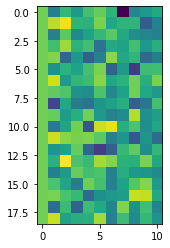

In [0]:
# Initialize empty x
X = np.zeros((n,p))

# First column is intercept
X[:,0] = 1

# Rest of the columns we will make random noise 
X[:,1:] = np.random.randn(n*(p-1)).reshape((n,(p-1)))

# Image of the last 20 rows of X
imshow(X[-20:-1,:])


#### Random Effects matrix (Z)

For simplicity, in this example $Z$ is the same for all voxels. 

[14  5]
[2 5]


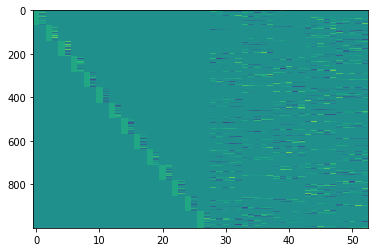

In [0]:
import sparse
# We need to create a block of Z for each level of each factor
for i in np.arange(r):
  
  Zdata_factor = np.random.randn(n,nparams[i])
  
  if i==0:
    
    #The first factor should be block diagonal, so the factor indices are grouped
    factorVec = np.repeat(np.arange(nlevels[i]), repeats=np.floor(n/max(nlevels[i],1)))
    
    if len(factorVec) < n:
      
      # Quick fix incase rounding leaves empty columns
      factorVecTmp = np.zeros(n)
      factorVecTmp[0:len(factorVec)] = factorVec
      factorVecTmp[len(factorVec):n] = nlevels[i]-1
      factorVec = np.int64(factorVecTmp)
      
    
    # Crop the factor vector - otherwise have a few too many
    factorVec = factorVec[0:n]
    
    # Give the data an intercept
    Zdata_factor[:,0]=1
    
  else:
    
    # The factor is randomly arranged across subjects
    factorVec = np.random.randint(0,nlevels[i],size=n) 
  
  # Build a matrix showing where the elements of Z should be
  indicatorMatrix_factor = np.zeros((n,nlevels[i]))
  indicatorMatrix_factor[np.arange(n),factorVec] = 1
  
  # Need to repeat for each parameter the factor has 
  indicatorMatrix_factor = np.repeat(indicatorMatrix_factor, nparams[i], axis=1)
  
  # Enter the Z values
  indicatorMatrix_factor[indicatorMatrix_factor==1]=Zdata_factor.reshape(Zdata_factor.shape[0]*Zdata_factor.shape[1])
  
  # Make sparse
  Zfactor = scipy.sparse.csr_matrix(indicatorMatrix_factor)

  # Put all the factors together
  if i == 0:
    Z = Zfactor
  else:
    Z = scipy.sparse.hstack((Z, Zfactor))


Z2 = sparse.COO.from_scipy_sparse(Z)

# Create an image of Z
imshow(Z.toarray(), \
       interpolation='nearest', vmin=-5, vmax=5, aspect='auto')

print(nlevels)
print(nparams)


#### Smooth random beta
Smooth random beta image.

0.014941215515136719


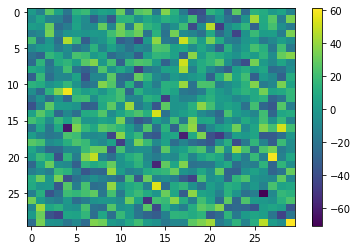

In [0]:
# Random 4D matrix (unsmoothed)
beta_us = np.random.randn(nv*p).reshape(dimv[0],dimv[1],dimv[2],p)*20
beta_us[10:15,10:15,10:15,3] = beta_us[10:15,10:15,10:15,3] + 100

t1 = time.time()
# Some random affine, not important for this simulation
affine = np.diag([1, 1, 1, 1])
beta_us_nii = nib.Nifti1Image(beta_us, affine)

# Smoothed beta nifti
beta_s_nii = nilearn.image.smooth_img(beta_us_nii, 5)

# Final beta
beta = beta_s_nii.get_fdata()

t2 = time.time()
print(t2-t1)

# Show unsmoothed
imshow(beta_us[3,:,:,3].reshape(dimv[0],dimv[1]), \
                    interpolation='nearest', aspect='auto')

plt.colorbar()

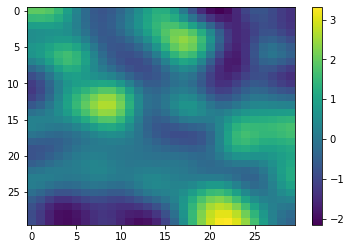

In [0]:
# Show smoothed
imshow(beta[3,:,:,3].reshape(dimv[0],dimv[1]), \
                    interpolation='nearest', aspect='auto')
plt.colorbar()

#### Smooth random b
Smooth random b image.

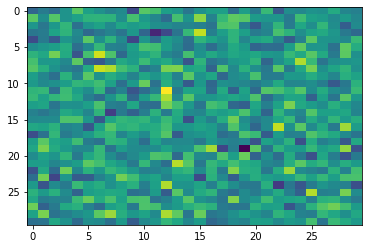

In [0]:
# Random 4D matrix (unsmoothed)
b_us = np.random.randn(nv*q).reshape(dimv[0],dimv[1],dimv[2],q)*20

# Some random affine, not important for this simulation
affine = np.diag([1, 1, 1, 1])
b_us_nii = nib.Nifti1Image(b_us, affine)

# Smoothed beta nifti
b_s_nii = nilearn.image.smooth_img(b_us_nii, 5)

# Final beta
b = b_s_nii.get_fdata()

# Show unsmoothed
imshow(b_us[3,:,:,1].reshape(dimv[0],dimv[1]), \
                    interpolation='nearest', aspect='auto')

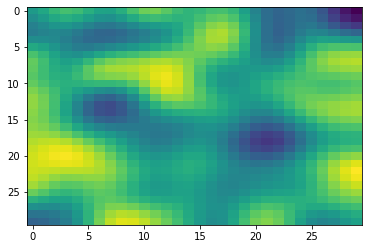

In [0]:
# Show smoothed
imshow(b[3,:,:,1].reshape(dimv[0],dimv[1]), \
                    interpolation='nearest', aspect='auto')

 #### Y vector (New response)
 
Generate response for the whole field.

In [0]:

# Reshape X
X = X.reshape(1, X.shape[0], X.shape[1])

# Reshape beta
beta = beta.reshape(beta.shape[0]*beta.shape[1]*beta.shape[2],beta.shape[3],1)
beta_True = beta

# Reshape Z (note: This step is slow because of the sparse to dense conversion;
# it could probably be made quicker but this is only for one simulation at current)
Ztmp = Z.toarray().reshape(1, Z.shape[0], Z.shape[1])

# Reshape b
b = b.reshape(b.shape[0]*b.shape[1]*b.shape[2],b.shape[3],1)

print(X.shape)
print(Ztmp.shape)
print(beta.shape)
print(b.shape)

# Generate Y
Y = np.matmul(X,beta)+np.matmul(Ztmp,b) + np.random.randn(n,1)

(1, 1000, 11)
(1, 1000, 53)
(27000, 11, 1)
(27000, 53, 1)


Check Y looks reasonable.

(27000, 1000, 1)


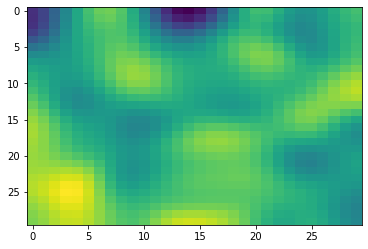

In [0]:
print(Y.shape)

Y_imageformat = Y.reshape((dimv[0],dimv[1],dimv[2],n))

imshow(Y_imageformat[3,:,:,1].reshape(dimv[0],dimv[1]), \
                    interpolation='nearest', aspect='auto')

#### Transpose products

Calculate X'Y, X'Z, X'Y, Y'Y, Y'Z, Y'X Z'Z, Z'X and Z'Y.

In [0]:
# X'Z\Z'X
XtZ = np.matmul(X.transpose(0,2,1),Ztmp)
ZtX = XtZ.transpose(0,2,1)

# Z'Y\Y'Z
YtZ = np.matmul(Y.transpose(0,2,1),Ztmp)
ZtY = YtZ.transpose(0,2,1)

# Y'X/X'Y
YtX = np.matmul(Y.transpose(0,2,1),X)
XtY = YtX.transpose(0,2,1)

# YtY
YtY = np.matmul(Y.transpose(0,2,1),Y)

# ZtZ
ZtZ = np.matmul(Ztmp.transpose(0,2,1),Ztmp)

# X'X
XtX = np.matmul(X.transpose(0,2,1),X)


print(XtZ.shape)
print(ZtX.shape)

print(XtY.shape)
print(YtX.shape)

print(YtZ.shape)
print(ZtY.shape)

print(XtX.shape)

print(YtY.shape)

print(ZtZ.shape)

(1, 11, 53)
(1, 53, 11)
(27000, 11, 1)
(27000, 1, 11)
(27000, 1, 53)
(27000, 53, 1)
(1, 11, 11)
(27000, 1, 1)
(1, 53, 53)


### Demonstration: Time taken just looping

This is a demonstration showing how long FS takes when doing each voxel seperately.

In [0]:
# Initialize empty estimates
beta_est = np.zeros(beta.shape)
print(beta.shape)

demo = False
if demo:
  
  # Initialize temporary X'X, X'Z, Z'X and Z'Z
  XtZtmp = XtZ[0,:,:]
  ZtXtmp = ZtX[0,:,:]
  ZtZtmp = ZtZ[0,:,:]
  XtXtmp = XtX[0,:,:]

  print(type(ZtZ))

  t1 = time.time()
  for i in np.arange(beta.shape[0]):

    print(i)

    XtYtmp = XtY[i,:,:]
    ZtYtmp = ZtY[i,:,:] 
    YtYtmp = YtY[i,:,:] 
    YtZtmp = YtZ[i,:,:]
    YtXtmp = YtX[i,:,:]

    param_est,bvals = FS(XtXtmp, XtYtmp, ZtXtmp, ZtYtmp, ZtZtmp, XtZtmp, YtZtmp, YtYtmp, YtXtmp, nlevels, nparams, 1e-6, n)

    # Get current beta
    beta_est[i,:,:] = param_est[0:beta.shape[1]]

  t2 = time.time()
  print("Time taken in seconds for this example:")
  print(t2-t1)
  print("Estimated time taken for this example on a nifti of size (100x100x100), in hours:")
  print(100*100*100*(t2-t1)/(nv*60*60))

(27000, 11, 1)


True beta (3)


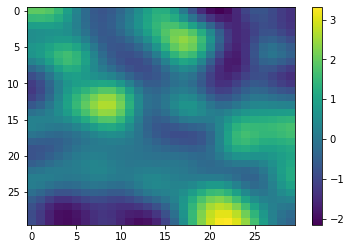

In [0]:
print("True beta (3)")
beta_map=beta.reshape(dimv[0],dimv[1],dimv[2],beta.shape[1])
beta_est_map=beta_est.reshape(dimv[0],dimv[1],dimv[2],beta.shape[1])


# Show true beta, 3rd x-slice, 3rd parameter
imshow(beta_map[3,:,:,3].reshape(dimv[0],dimv[1]), \
                    interpolation='nearest', aspect='auto')
plt.colorbar()

Estimated beta (3)


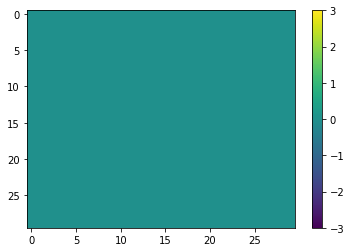

In [0]:
print("Estimated beta (3)")

# Show estimated beta, 3rd x-slice, 3rd parameter
imshow(beta_est_map[3,:,:,3].reshape(dimv[0],dimv[1]), vmin=-3, vmax=3, \
                    interpolation='nearest', aspect='auto')
plt.colorbar()


**Note:** Result is roughly similar... but lots of local minima disrupting the image.

### Scaled up Helper Functions

This section contains the Nifti-equivalent functions to those given *helper functions* for an individual voxel.

#### Initial beta (broadcasted)

The below function returns the OLS estimator for several voxels at once, where the OLS estimator for a given voxel, $\hat{\beta}$, is given by:

$$\hat{\beta}_{OLS}=(X'X)^{-1}X'Y$$

----

This function takes the following inputs:

----

 - `XtX`: The design matrices transposed and multiplied by themselves ($X'X$ in the above notation)
 - `XtY`: The design matrices transposed and multiplied by the response vectors ($X'Y$ in the above notation).
 
----

It returns as outputs:

----

- `beta`: The OLS estimates of $\beta$ ($\hat{\beta}_{OLS}$ in the above notation).



In [0]:
def initBeta_broadcasted(XtX, XtY):
  
  # Get the beta estimator
  beta = np.linalg.solve(XtX,XtY)
  
  # Return the result
  return(beta)

print(initBeta(XtX,XtY))
print(np.linalg.inv(XtX) @ XtY)

[[[-0.84343553]
  [ 0.12088461]
  [ 0.71867051]
  ...
  [ 2.8935947 ]
  [-0.67459789]
  [-3.08122112]]

 [[-1.15673532]
  [ 0.19642787]
  [ 0.02968513]
  ...
  [ 2.36591741]
  [-1.12653006]
  [-3.83697017]]

 [[-1.51847724]
  [ 0.36027867]
  [-1.05392769]
  ...
  [ 1.65868609]
  [-1.6253267 ]
  [-4.65289381]]

 ...

 [[ 0.3159518 ]
  [-4.31100121]
  [-0.08756585]
  ...
  [ 3.92723822]
  [ 1.89555932]
  [ 2.2944746 ]]

 [[ 0.5566827 ]
  [-4.47989404]
  [ 0.02129297]
  ...
  [ 3.65367182]
  [ 2.48438265]
  [ 1.54267973]]

 [[ 0.77725834]
  [-4.48429482]
  [ 0.08583648]
  ...
  [ 3.34941247]
  [ 2.76242843]
  [ 0.91854611]]]
[[[-0.84343553]
  [ 0.12088461]
  [ 0.71867051]
  ...
  [ 2.8935947 ]
  [-0.67459789]
  [-3.08122112]]

 [[-1.15673532]
  [ 0.19642787]
  [ 0.02968513]
  ...
  [ 2.36591741]
  [-1.12653006]
  [-3.83697017]]

 [[-1.51847724]
  [ 0.36027867]
  [-1.05392769]
  ...
  [ 1.65868609]
  [-1.6253267 ]
  [-4.65289381]]

 ...

 [[ 0.3159518 ]
  [-4.31100121]
  [-0.08756585]
  ..

### Block to stacked matrix (3D)

In [0]:
def block2stacked3D(A, pA):

  # Work out shape of A
  v = A.shape[0] # (Number of voxels)
  m1 = A.shape[1]
  m2 = A.shape[2]

  # Work out shape of As
  n1 = pA[0]
  n2 = pA[1]
  
  # Change A to stacked form
  As = A.reshape((v,m1//n1,n1,m2//n2,n2)).transpose(0,1,3,2,4).reshape(v,m1*m2//n2,n2)

  return(As)

The below code checks the above function against it's 2D counterpart.

In [0]:
# Random block sizes
n1 = np.random.randint(2,60)
n2 = np.random.randint(2,60)
pA = np.array([n1,n2])

# Number of voxels 
v = 100

# Random number of blocks
l1 = np.random.randint(1,31)
l2 = np.random.randint(1,31)

# Shape of A
m1 = l1*n1
m2 = l2*n2

# Create A
A = np.random.randn(v,m1,m2)
print(v,n1,n2,m1,m2)
print(A.shape)

# Some index, i
i = 6

# Print A
print(np.allclose(block2stacked3D(A,pA)[i,:,:],block2stacked2D(A[i,:,:],pA)))

100 7 41 56 902
(100, 56, 902)
True


### Convert Blocked matrix to stacked vector format

In [0]:
# Block vec with row-wise chunks of size n
def mat2vecb3D(mat,p):

  # Change to stacked block format, if necessary
  if p[1]!=mat.shape[2]:
    mat = block2stacked3D(mat,p)

  # Get height of block.
  n = p[0]
  
  # Work out shape of matrix.
  v = mat.shape[0]
  m = mat.shape[1]
  k = mat.shape[2]

  # Convert to stacked vector format
  vecb = mat.reshape(v,m//n, n, k).transpose((0,2, 1, 3)).reshape(v,n, m*k//n).transpose((0,2,1)).reshape(v,m//n,n*k)

  #Return vecb
  return(vecb)

The below code tests the above function against it's 2D counterpart.

In [0]:
# Random block sizes
n1 = np.random.randint(2,4)
n2 = np.random.randint(2,4)

# Number of voxels
v = 100

# Blocksize
p = np.array([n1,n2])

# Random number of blocks
l1 = np.random.randint(2,4)
l2 = np.random.randint(2,4)

# Resultant matrix sizes
m1 = l1*n1
m2 = l2*n2

# Random matrices
A = np.random.randn(v,m1,m2)

# Random index i
i = 9

print(np.allclose(mat2vecb3D(A,p)[i,:,:],mat2vecb2D(A[i,:,:],p)))

True


### Block sum of Aij Bij transpose

In [0]:
def sumAijBijt3D(A, B, pA, pB):
  
  # Number of voxels
  v = A.shape[0]

  # Work out second (the common) dimension of the reshaped A and B
  nA = pA[0]
  nB = pB[0]

  # Work out the first (the common) dimension of reshaped A and B
  mA = A.shape[1]*A.shape[2]//nA
  mB = B.shape[1]*B.shape[2]//nB

  # Check mA equals mB
  if mA != mB:
    raise Exception('Matrix dimensions incompatible.')

  # Convert both matrices to stacked block format.
  A = block2stacked3D(A,pA)
  B = block2stacked3D(B,pB)

  # Work out the sum
  S = A.transpose((0,2,1)).reshape((v,mA,nA)).transpose((0,2,1)) @ B.transpose((0,2,1)).reshape((v,mB,nB))

  # Return result
  return(S)

The below code tests the 3D function above against it's 2D counterpart.

In [0]:
# Random number of blocks
l1 = np.random.randint(1,300)
l2 = np.random.randint(1,300)

# Random blocksizes (the second dimension must be the same for both)
n1 = np.random.randint(1,5)
n1prime = np.random.randint(1,5)
n2 = np.random.randint(1,5)

# Number of voxels
v = 61

# Save block sizes
pA = np.array([n1,n2])
pB = np.array([n1prime,n2])

m1 = n1*l1
m1prime = n1prime*l1
m2 = n2*l2

k=100
l1 = m1//n1
l2 = m2//n2

# Create A
A = np.random.randn(v,m1,m2)
B = np.random.randn(v,m1prime,m2)

# index i
i = 24

sumAB = sumAijBijt2D(A[i,:,:], B[i,:,:], pA, pB)
sumAB2 = sumAijBijt3D(A, B, pA, pB)[i,:,:]

print(np.allclose(sumAB,sumAB2))

True


#### Matrix to Vector (broadcasted)

This function takes in a stack of matrices and returns the corresponding vectorized forms of those matrices.

In [0]:
def mat2vec_broadcasted(matrix):
  
  #Return vectorised matrix
  return(matrix.transpose(0,2,1).reshape(matrix.shape[0],matrix.shape[1]*matrix.shape[2],1))

# Example:
matrix = np.random.randn(4,3,3)
print(matrix)
print(mat2vec_broadcasted(matrix))

[[[ 1.12152257 -0.53891485 -0.79545757]
  [-0.44217089 -0.32010966 -0.95993104]
  [-0.25283493 -0.0387094   0.38020377]]

 [[ 1.57829504 -0.29963826 -0.05018347]
  [ 0.43797271 -0.4446755  -0.26737488]
  [-1.76171449 -1.68142624  0.14159867]]

 [[-0.46632936 -1.3517203  -0.13465773]
  [-0.48191413 -0.62318696 -0.74503883]
  [ 0.27666878  0.35333285  0.02270484]]

 [[ 0.41791691  0.90898366  1.01505147]
  [-0.94352414  0.38345845  0.70748432]
  [-2.1325694  -1.42764497  0.35452556]]]
[[[ 1.12152257]
  [-0.44217089]
  [-0.25283493]
  [-0.53891485]
  [-0.32010966]
  [-0.0387094 ]
  [-0.79545757]
  [-0.95993104]
  [ 0.38020377]]

 [[ 1.57829504]
  [ 0.43797271]
  [-1.76171449]
  [-0.29963826]
  [-0.4446755 ]
  [-1.68142624]
  [-0.05018347]
  [-0.26737488]
  [ 0.14159867]]

 [[-0.46632936]
  [-0.48191413]
  [ 0.27666878]
  [-1.3517203 ]
  [-0.62318696]
  [ 0.35333285]
  [-0.13465773]
  [-0.74503883]
  [ 0.02270484]]

 [[ 0.41791691]
  [-0.94352414]
  [-2.1325694 ]
  [ 0.90898366]
  [ 0.3834

#### Sum of Aij kron Bij

In [0]:
def sumAijKronBij3D(A, B, p, perm=None):

  # Check dim A and B and pA and pB all same
  n1 = p[0]
  n2 = p[1]

  # Number of voxels
  v = A.shape[0]

  # This matrix only needs be calculated once
  if perm is None:
    perm = permOfIkKkI(n2,n1,n2,n1) 

  # Convert to vecb format
  atilde = mat2vecb3D(A,p)
  btilde = mat2vecb3D(B,p)

  # Multiply and convert to vector
  vecba = mat2vec_broadcasted(btilde.transpose((0,2,1)) @ atilde)

  # Permute
  S_noreshape = vecba[:,perm,:] 

  # Reshape to correct shape
  S = S_noreshape.reshape(v,n2**2,n1**2).transpose((0,2,1))

  return(S,perm)

The below code tests the above function against it's 2D counterpart.

In [0]:
# Random block sizes
n1 = np.random.randint(2,10)
n2 = np.random.randint(2,10)

# Number of voxels 
v = 37

# Blocksize
p = np.array([n1,n2])

# Random number of blocks
l1 = np.random.randint(2,30)
l2 = np.random.randint(2,30)

# Resultant matrix sizes
m1 = l1*n1
m2 = l2*n2

# Random matrices
A = np.random.randn(v,m1,m2)
B = np.random.randn(v,m1,m2)

# Index i
i = 17

# Now with function
S,_ = sumAijKronBij2D(A[i,:,:], B[i,:,:], p)
S2,_ = sumAijKronBij3D(A, B, p)
S2 = S2[i,:,:]

print(np.allclose(S,S2))
#print(S)
#print(runningSum)

True


### Sum of square residuals (broadcasted)

> Indented block



The function below calculates the sum of the square residuals, $e^Te$, using the below formula:

$$e^Te = (Y-X\beta)^T(Y-X\beta)$$ 
$$=Y^TY - 2Y^TX\beta + \beta^T X^TX \beta$$


----

This function takes the following inputs:

----

 - `YtX`: $Y$ transpose multiplied by $X$ ($Y^TX$ in the above notation).
 - `YtY`: $Y$ transpose multiplied by $Y$ ($Y^TY$ in the above notation).
 - `XtX`: $X$ transpose multiplied by $X$ ($X^TX$ in the above notation).
 - `beta`: An estimate of the parameter vector ($\beta$ in the above notation).
 
----

It returns as outputs:

----


 - `ete`: The sum of square residuals ($e^Te$ in the above notation).

In [0]:
def ssr_broadcasted(YtX, YtY, XtX, beta):
  
  # Return the sum of squared residuals
  return(YtY - 2*YtX @ beta + beta.transpose((0,2,1)) @ XtX @ beta)

print(ssr_broadcasted(YtX,YtY,XtX,initBeta(XtX,XtY)))

#### Initial Sigma (Broadcasted)

The function below returns an initial estimate for the Fixed Effects Variance, $\sigma^2$. The estimator used is based on the suggested OLS estimator in Demidenko (2012) and is given by:

$$\hat{\sigma}^2_{OLS}=\frac{1}{n}(Y-X\beta)^T(Y-X\beta)$$
$$=\frac{1}{n}e^Te$$

----

This function takes the following inputs:

----

 - `ete`: The sum of square residuals ($e^Te$ in the above notation).
 - `n`: The total number of observations ($n$ in the above notation).
 
----

It returns as outputs:

----

- `sigma2`: The OLS estimate of $\sigma^2$ ($\hat{\sigma}^2_{OLS}$ in the above notation).

In [0]:
def initSigma2_broadcasted(ete, n):

  # Return the OLS estimate of sigma
  return(1/n*ete[:,0,0])

print(initSigma2_broadcasted(ssr_broadcasted(YtX,YtY,XtX,initBeta(XtX,XtY)),n))

### Kron (broadcasted)

Taken from https://stackoverflow.com/questions/57259557/kronecker-product-of-matrix-array

In [0]:
def kron_broadcasted(A,B):
  i,j,k = A.shape
  i,l,m = B.shape
  return(np.einsum("ijk,ilm->ijlkm",A,B).reshape(i,j*l,k*m))

#### Vector to matrix (broadcasted)

This function takes in a stack of vectors and returns the corresponding matrix forms of those vectors.

In [0]:
def vec2mat_broadcasted(vec):
  
  # Return matrix
  return(vec.reshape(vec.shape[0], np.int64(np.sqrt(vec.shape[1])),np.int64(np.sqrt(vec.shape[1]))).transpose(0,2,1))

# Example
vec = np.random.randn(4,4,1)
mat = vec2mat_broadcasted(vec)
print(vec)
print(mat)

#### Matrix to half vector (broadcasted)

This function takes in a stack of matrices and returns the corresponding vector forms of the lower halves of those matrices.

In [0]:
def mat2vech_broadcasted(matrix):
  
  # Number of voxels, nv
  nv = matrix.shape[0]
  
  # Get lower triangular indices
  rowinds, colinds = np.tril_indices(matrix.shape[1]) 
  
  # Number of covariance parameters, nc
  nc = len(rowinds)
  
  # They're in the wrong order so we need to order them
  # To do this we first hash them
  indhash = colinds*matrix.shape[1]+rowinds
  
  # Sort permutation
  perm=np.argsort(indhash)
  
  # Return vectorised half-matrix
  return(matrix[:,rowinds[perm],colinds[perm]].reshape((nv,nc,1)))

#### Half vector to matrix (broadcasted)

This function takes in a stack of vectors and returns the corresponding matrix forms treating the elements of the vectors as the elements of lower halves of those matrices.

In [0]:
def vech2mat_broadcasted(vech):
  
  # Number of voxels
  nv = vech.shape[0]
  
  # dimension of matrix
  n = np.int64((-1+np.sqrt(1+8*vech.shape[1]))/2)
  matrix = np.zeros((nv,n,n))
  
  # Get lower triangular indices
  rowinds, colinds = np.tril_indices(n)
  
  # They're in the wrong order so we need to order them
  # To do this we first hash them
  indhash = colinds*n+rowinds
  
  # Sort permutation
  perm=np.argsort(indhash)
  
  # Assign values to lower half
  matrix[:,rowinds[perm],colinds[perm]] = vech.reshape(vech.shape[0],vech.shape[1])
  
  # Assign values to upper half
  matrix[:,colinds[perm],rowinds[perm]] = vech.reshape(vech.shape[0],vech.shape[1])
  
  # Return vectorised half-matrix
  return(matrix)


#### Initial D_k (broadcasted)

The function below returns an initial estimate for the Random Effects Variance matrix for the $k^{th}$ grouping factor, $D_k$. The estimator used is an adaption of the suggested estimator in Demidenko (2012) and is given by:

$$vec(\hat{D}_{k})=\bigg[\sum_{j=1}^{l_k}(Z_{(k,j)}^TZ_{(k,j)}) \otimes (Z_{(k,j)}^TZ_{(k,j)})\bigg]^{-1}vec\bigg(\sum_{j=1}^{l_k}[\hat{\sigma}^{-2}_{OLS}Z_{(k,j)}^Tee^TZ_{(k,j)} - Z_{(k,j)}^TZ_{(k,j)}]\bigg)$$

Or:

$$\hat{D}_{k}=matrix\bigg(\bigg[\sum_{j=1}^{l_k}(Z_{(k,j)}^TZ_{(k,j)}) \otimes (Z_{(k,j)}^TZ_{(k,j)})\bigg]^{-1}vec\bigg(\sum_{j=1}^{l_k}[\hat{\sigma}^{-2}_{OLS}Z_{(k,j)}^Tee^TZ_{(k,j)} - Z_{(k,j)}^TZ_{(k,j)}]\bigg)\bigg)$$

----

This function takes the following inputs:

----

 - `k`: The grouping factor we wish to estimate $D$ for ($k$ in the above notation)
 - `lk`: The number of levels belonging to grouping factor $k$ ($l_k$ in the above notation).
 - `ZtZ`: The $Z$ matrix transposed and then multiplied by itself ($Z^TZ$ in the above notation).
 - `Zte`: The $Z$ matrix transposed and then multiplied by the OLS residuals ($Z^Te=Z^T(Y-X\beta)$ in the above notation).
 - `sigma2`: The OLS estimate of $\sigma^2$ ($\hat{\sigma}^2_{OLS}$ in the above notation).
 
----

It returns as outputs:

----

- `Dkest`: The inital estimate of $D_k$ ($\hat{D}_k$ in the above notation).


###CHECK DERIVATION

In [0]:
def initDk_broadcasted(k, lk, ZtZ, Zte, sigma2):
  
  # Initalize D to zeros
  invSig2ZteetZminusZtZ = np.zeros((Zte.shape[0],nparams[k],nparams[k]))
  
  # For each level j we need to add a term
  for j in np.arange(nlevels[k]):
    
    Ikj = faclev_indices(k, j, nlevels, nparams)

    # Work out Z_(k, j)'Z_(k, j)
    ZkjtZkj = ZtZ[np.ix_(np.arange(ZtZ.shape[0]),Ikj,Ikj)]
    
    # Work out Z_(k,j)'e
    Zkjte = Zte[:, Ikj,:]
    
    if j==0:
      
      # Add first Z_(k,j)'Z_(k,j) kron Z_(k,j)'Z_(k,j)
      ZtZkronZtZ = kron_broadcasted(ZkjtZkj,ZkjtZkj.transpose(0,2,1))
      
      # Add first \sigma^{-2}Z'ee'Z - Z_(k,j)'Z_(k,j)
      invSig2ZteetZminusZtZ = np.einsum('i,ijk->ijk',1/sigma2,(Zkjte @ Zkjte.transpose(0,2,1))) - ZkjtZkj
      
    else:
      
      # Add next Z_(k,j)'Z_(k,j) kron Z_(k,j)'Z_(k,j)
      ZtZkronZtZ = ZtZkronZtZ + kron_broadcasted(ZkjtZkj,ZkjtZkj.transpose(0,2,1))
      
      # Add next \sigma^{-2}Z'ee'Z - Z_(k,j)'Z_(k,j)
      invSig2ZteetZminusZtZ = invSig2ZteetZminusZtZ + np.einsum('i,ijk->ijk',1/sigma2,(Zkjte @ Zkjte.transpose(0,2,1))) - ZkjtZkj
      
  # Work out the final term.
  Dkest = vec2mat_broadcasted(np.linalg.inv(ZtZkronZtZ) @ mat2vec_broadcasted(invSig2ZteetZminusZtZ)) 
  
  
  return(Dkest)

Zte = ZtY-ZtX @ np.random.randn(ZtY.shape[0],ZtX.shape[2],1)

t1 = time.time()
initDk_broadcasted(0, nlevels[0], ZtZ, Zte , np.ones(Zte.shape[0]))
t2 = time.time()

print(t2-t1)

t1 = time.time()
initDk_broadcasted(0, nlevels[0], ZtZ, Zte , np.ones(Zte.shape[0]))
t2 = time.time()

print(t2-t1)

print(initDk_broadcasted(0, nlevels[0], ZtZ, Zte , np.ones(Zte.shape[0]))[8,:,:])

t1 = time.time()
print(initDk(0, nlevels[0], ZtZ[0,:,:], Zte[8,:,:], 1))
t2 = time.time()

print(t2-t1)

#### Make D non-negative definite (Broadcasted)

This function projects a stack of matrices into the space of non-negative definite matrices.

In [0]:
def makeDnnd_broadcasted(D):
  
  # Check if we have negative eigenvalues
  if not np.all(np.linalg.eigvals(D)>0):
  
    # If we have negative eigenvalues
    eigvals,eigvecs = np.linalg.eigh(D)
    
    # Work out elementwise max of lambda and 0
    lamplus = np.zeros((eigvals.shape[0], eigvals.shape[1], eigvals.shape[1]))
    diag = np.arange(eigvals.shape[1])
    lamplus[:, diag, diag] = np.maximum(eigvals,0)
    
    # Work out D+
    D_nnd = eigvecs @ lamplus @ np.linalg.inv(eigvecs)
    
  else:
    
    # D is already non-negative in this case
    D_nnd = D
    
  return(D_nnd)
  
D = np.random.randn(100000,3,3)
t1 = time.time()
print(makeDnnd_broadcasted(D)[10,:,:])
t2 = time.time()
print(t2-t1)
t1 = time.time()
print(makeDnnd(D[10,:,:]))
t2 = time.time()
print(t2-t1)


### COULD BE IMPROVED SPEED WISE

### Get D from dict (broadcasted)

This function takes in a dictionary, `Ddict`, in which entry `k` is a stack of the $k^{th}$ diagonal block for every voxel.

In [0]:
def getDfromDict_broadcasted(Ddict, nparams, nlevels):
  
  # Get number of voxels
  nv = Ddict[0].shape[0]
  
  # Work out indices (there is one block of D per level)
  inds = np.zeros(np.sum(nlevels)+1)
  counter = 0
  for k in np.arange(len(nparams)):
    for j in np.arange(nlevels[k]):
      inds[counter] = np.concatenate((np.array([0]), np.cumsum(nlevels*nparams)))[k] + nparams[k]*j
      counter = counter + 1
      
  
  # Last index will be missing so add it
  inds[len(inds)-1]=inds[len(inds)-2]+nparams[-1]
  
  # Make sure indices are ints
  inds = np.int64(inds)
  
  # Initial D
  D = np.zeros((nv,np.sum(nparams*nlevels),np.sum(nparams*nlevels)))

  counter = 0
  for k in np.arange(len(nparams)):
    for j in np.arange(nlevels[k]):

      D[:, inds[counter]:inds[counter+1], inds[counter]:inds[counter+1]] = Ddict[k]
      counter = counter + 1
  
  return(D)
  
# Example dict
nparams_tmp = np.array([10,2,3])
nlevels_tmp = np.array([30,22,4])

Ddict_tmp = dict()
for i in np.arange(len(nparams_tmp)):
  
  Ddict_tmp[i] = np.random.randn(2000,nparams_tmp[i],nparams_tmp[i])

t1 = time.time()
D = getDfromDict_broadcasted(Ddict_tmp, nparams_tmp, nlevels_tmp)
t2 = time.time()
print(t2-t1)

#### Force Symmetric (Broadcasted)

This function forces a stack of matrices to be symmetric.

In [0]:
# Developer NOTE: DO NOT USE NUMBA ON THIS FUNCTION - NUMBA BUGGERS IT UP FOR UNKNOWN REASONS
def forceSym_broadcasted(x):
  
  # Force it to be symmetric
  return((x+x.transpose((0,2,1)))/2)

  
print(ZtZ.shape)
t1 = time.time()
ZtZ = forceSym_broadcasted(forceSym_broadcasted(ZtZ))
print(time.time()-t1)

print(ZtZ.shape)
t1 = time.time()
ZtZ = forceSym_broadcasted(forceSym_broadcasted(ZtZ))
print(time.time()-t1)

#### Derivative of $\frac{\delta l}{\delta \beta}$ (broadcasted)

This function returns the derivative of $l$ with respect to $\beta$ for all voxels.

In [0]:
def get_dldB_broadcasted(sigma2, Xte, XtZ, DinvIplusZtZD, Zte):
  
  # Work out the derivative (Note: we leave everything as 3D for ease of future computation)
  deriv = np.einsum('i,ijk->ijk',1/sigma2, (Xte - (XtZ @ DinvIplusZtZD @ Zte)))
                    
  # Return the derivative
  return(deriv)

#### Derivative of $\frac{\delta l}{\delta \sigma^2}$ (broadcasted)

This function returns the derivative of $l$ with respect to $\sigma^2$ for all voxels.

In [0]:
def get_dldsigma2_broadcasted(n, ete, Zte, sigma2, DinvIplusZtZD):
  
  # Get e'(I+ZDZ')^(-1)e=e'e-e'ZD(I+Z'ZD)^(-1)Z'e
  etinvIplusZtDZe = ete - forceSym_broadcasted(Zte.transpose((0,2,1)) @ DinvIplusZtZD @ Zte)
  
  # Get the derivative
  deriv = -n/(2*sigma2) + np.einsum('i,ijk->ijk',1/(2*(sigma2**2)), etinvIplusZtDZe).reshape(sigma2.shape[0])
  
  return(deriv)

#### Derivative of $\frac{\delta l}{\delta D_k}$ (broadcasted)

This function returns the derivative of $l$ with respect to $D_k$ for all voxels.

In [0]:
def get_dldDk_broadcasted(k, nlevels, nparams, ZtZ, Zte, sigma2, DinvIplusZtZD):

  # Number of voxels
  nv = Zte.shape[0]
  
  # Initalize the derivative to zeros
  dldDk = np.zeros((nv, nparams[k],nparams[k]))
  
  # For each level j we need to add a term
  for j in np.arange(nlevels[k]):

    # Get the indices for the kth factor jth level
    Ikj = faclev_indices(k, j, nlevels, nparams)
    
    # Get (the kj^th columns of Z)^T multiplied by Z
    Z_kjtZ = ZtZ[:,Ikj,:]
    Z_kjte = Zte[:,Ikj,:]
    
    # Get the first term of the derivative
    Z_kjtVinve = Z_kjte - (Z_kjtZ @ DinvIplusZtZD @ Zte)
    firstterm = np.einsum('i,ijk->ijk',1/sigma2,forceSym_broadcasted(Z_kjtVinve @ Z_kjtVinve.transpose((0,2,1))))
    
    # Get (the kj^th columns of Z)^T multiplied by (the kj^th columns of Z)
    Z_kjtZ_kj = ZtZ[np.ix_(np.arange(ZtZ.shape[0]),Ikj,Ikj)]
    secondterm = forceSym_broadcasted(Z_kjtZ_kj) - forceSym_broadcasted(Z_kjtZ @ DinvIplusZtZD @ Z_kjtZ.transpose((0,2,1)))
    
    if j == 0:
      
      # Start a running sum over j
      dldDk = firstterm - secondterm
      
    else:
    
      # Add these to the running sum
      dldDk = dldDk + firstterm - secondterm
    
  # Halve the sum (the coefficient of a half was not included in the above)
  dldDk = forceSym_broadcasted(dldDk/2)

  # Store it in the dictionary
  return(dldDk)

#### Covariance of derivative of $\frac{\delta l}{\delta \beta}$ (broadcasted)

This function returns the covariance of the derivative of $l$ with respect to $\beta$ for all voxels.

In [0]:
def get_covdldbeta_broadcasted(XtZ, XtX, ZtZ, DinvIplusZtZD, sigma2):
  
  # Get the covariance of the derivative
  covderiv = np.einsum('i,ijk->ijk',1/sigma2,(XtX - forceSym_broadcasted(XtZ @ DinvIplusZtZD @ XtZ.transpose((0,2,1)))))
  
  # Return the covariance of the derivative
  return(covderiv)

#### Covariance of derivative of $\frac{\delta l}{\delta \sigma^2}$ and $\frac{\delta l}{\delta D_k}$ (broadcasted)

This function returns the covariance of the derivative of $l$ with respect to $\sigma^2$ and $D_k$ for all voxels.

In [0]:
def get_covdldDkdsigma2_broadcasted(k, sigma2, nlevels, nparams, ZtZ, DinvIplusZtZD, invDupMatdict):
  
  # Number of voxels
  nv = DinvIplusZtZD.shape[0]
  
  # Sum of R_(k, j) over j
  RkSum = np.zeros((nv,nparams[k],nparams[k]))

  for j in np.arange(nlevels[k]):

    # Get the indices for the kth factor jth level
    Ikj = faclev_indices(k, j, nlevels, nparams)

    # Work out R_(k, j)
    Rkj = ZtZ[np.ix_(np.arange(ZtZ.shape[0]),Ikj,Ikj)] - forceSym_broadcasted(ZtZ[:,Ikj,:] @ DinvIplusZtZD @ ZtZ[:,:,Ikj])
    
    # Add together
    RkSum = RkSum + Rkj

  # Multiply by duplication matrices and save
  covdldDdldsigma2 = np.einsum('i,ijk->ijk', 1/(2*sigma2), invDupMatdict[k] @ mat2vec_broadcasted(RkSum))
  
  return(covdldDdldsigma2)

#### Covariance of derivative of $\frac{\delta l}{\delta D_{k_1}}$ and $\frac{\delta l}{\delta D_{k_2}}$ (broadcasted)

This function returns the covariance of the derivative of $l$ with respect to $D_{k_1}$ and $D_{k_2}$ for all voxels.

In [0]:
def get_covdldDk1Dk2_broadcasted(k1, k2, nlevels, nparams, ZtZ, DinvIplusZtZD, invDupMatdict):
  
  # Sum of R_(k1, k2, i, j) kron R_(k1, k2, i, j) over i and j 
  for i in np.arange(nlevels[k1]):

    for j in np.arange(nlevels[k2]):
      
      # Get the indices for the k1th factor jth level
      Ik1i = faclev_indices(k1, i, nlevels, nparams)
      Ik2j = faclev_indices(k2, j, nlevels, nparams)
      
      # Work out R_(k1, k2, i, j)
      Rk1k2ij = ZtZ[np.ix_(np.arange(ZtZ.shape[0]),Ik1i,Ik2j)] - (ZtZ[:,Ik1i,:] @ DinvIplusZtZD @ ZtZ[:,:,Ik2j])
      
      # Work out Rk1k2ij kron Rk1k2ij
      RkRt = kron_broadcasted(Rk1k2ij,Rk1k2ij)
      
      # Add together
      if (i == 0) and (j == 0):
      
        RkRtSum = RkRt
      
      else:
        
        RkRtSum = RkRtSum + RkRt
    
  # Multiply by duplication matrices and save
  covdldDk1dldk2 = 1/2 * invDupMatdict[k1] @ RkRtSum @ invDupMatdict[k2].transpose()
  
  # Return the result
  return(covdldDk1dldk2)


#### Log likelihood (broadcasted)

This function returns the loglikelihood for all voxels.

In [0]:
def llh_broadcasted(n, ZtZ, Zte, ete, sigma2, DinvIplusZtZD,D):
  
  # Work out -1/2(nln(sigma^2) + ln|I+Z'ZD|)
  firstterm = -0.5*(n*np.log(sigma2) + np.log(np.linalg.det(np.eye(ZtZ.shape[1]) + ZtZ @ D))).reshape(ete.shape[0])
                    
  # Work out sigma^(-2)*(e'e - e'ZD(I+Z'ZD)^(-1)Z'e)
  secondterm = -0.5*np.einsum('i,ijk->ijk',(1/sigma2),(ete - forceSym_broadcasted(Zte.transpose((0,2,1)) @ DinvIplusZtZD @ Zte))).reshape(ete.shape[0])
  
  # Work out the log likelihood
  llh = firstterm + secondterm
  
  # Return result
  return(llh)


In [0]:
def getConvergedIndices(convergedBeforeIt, convergedDuringIt):
  
  # ============================================================================
  # Global indices (i.e. relative to whole image)
  # ----------------------------------------------------------------------------
  
  # Numbers 1 to number of voxels
  indices = np.arange(len(convergedBeforeIt))
  
  # Indices of those which weren't converged before the iteration
  indices_notConBeforeIt = indices[convergedBeforeIt==0]
  
  # Indices of those which weren't converged after the iteration
  indices_notConAfterIt = indices_notConBeforeIt[convergedDuringIt==0]
  
  # Indices of those which were converged after iteration
  indices_ConAfterIt = np.setdiff1d(indices, indices_notConAfterIt)
  
  # Indices of those which converged during iteration
  indices_conDuringIt = np.setdiff1d(indices_notConBeforeIt, indices_notConAfterIt)
  
  # ============================================================================
  # Local indices (i.e. relative to current voxels)
  # ----------------------------------------------------------------------------
  local_converged = np.arange(len(convergedDuringIt))[convergedDuringIt==1]
  local_notconverged = np.arange(len(convergedDuringIt))[convergedDuringIt==0]
  
  return(indices_ConAfterIt, indices_notConAfterIt, indices_conDuringIt, local_converged, local_notconverged)

### Broadcasted FS

The below function performs FS for a NIFTI.

In [0]:
def FS_broadcasted(XtX, XtY, ZtX, ZtY, ZtZ, XtZ, YtZ, YtY, YtX, nlevels, nparams, tol,n):
  
  t1_total = time.time()
  t1 = time.time()
  
  # Useful scalars
  # ------------------------------------------------------------------------------

  # Number of factors, r
  r = len(nlevels)

  # Number of random effects, q
  q = np.sum(np.dot(nparams,nlevels))

  # Number of fixed effects, p
  p = XtX.shape[1]

  # Number of voxels, nv
  nv = XtY.shape[0]
  
  # Initial estimates
  # ------------------------------------------------------------------------------

  # Inital beta
  beta = initBeta_broadcasted(XtX, XtY)
  
  # Work out e'e, X'e and Z'e
  Xte = XtY - (XtX @ beta)
  Zte = ZtY - (ZtX @ beta)
  ete = ssr_broadcasted(YtX, YtY, XtX, beta)
  
  # Initial sigma2
  sigma2 = initSigma2_broadcasted(ete, n)

  Zte = ZtY - (ZtX @ beta) 
  
  # Inital D
  # Dictionary version
  Ddict = dict()
  for k in np.arange(len(nparams)):

    Ddict[k] = makeDnnd_broadcasted(initDk_broadcasted(k, nlevels[k], ZtZ, Zte, sigma2))
  
  # Full version of D
  D = getDfromDict_broadcasted(Ddict, nparams, nlevels)
  
  # Duplication matrices
  # ------------------------------------------------------------------------------
  invDupMatdict = dict()
  for i in np.arange(len(nparams)):

    invDupMatdict[i] = np.asarray(invDupMat(nparams[i]).todense())
  
  # Index variables
  # ------------------------------------------------------------------------------
  # Work out the total number of paramateres
  tnp = np.int32(p + 1 + np.sum(nparams*(nparams+1)/2))

  # Indices for submatrics corresponding to Dks
  FishIndsDk = np.int32(np.cumsum(nparams*(nparams+1)/2) + p + 1)
  FishIndsDk = np.insert(FishIndsDk,0,p+1)

  Zte = ZtY - (ZtX @ beta)
  
  # Inverse of (I+Z'ZD) multiplied by D
  IplusZtZD = np.eye(q) + ZtZ @ D
  DinvIplusZtZD =  forceSym_broadcasted(D @ np.linalg.inv(IplusZtZD)) 
  
  # Step size lambda
  lam = np.ones(nv)

  # Initial log likelihoods
  llhprev = -10*np.ones(XtY.shape[0])
  llhcurr = 10*np.ones(XtY.shape[0])
  
  # Vector checking if all voxels converged
  converged_global = np.zeros(nv)
  
  # Vector of saved parameters which have converged
  savedparams = np.zeros((nv, np.int32(np.sum(nparams*(nparams+1)/2) + p + 1),1))
  
  t2 = time.time()
  print('Setup time: ', t2-t1)
  
  nit=0
  while np.any(np.abs(llhprev-llhcurr)>tol):
    
    t1 = time.time()
    # Change current likelihood to previous
    llhprev = llhcurr
    
    # Work out how many voxels are left
    nv_iter = XtY.shape[0]
    
    # Derivatives
    # ----------------------------------------------------------------------------

    # Derivative wrt beta
    dldB = get_dldB_broadcasted(sigma2, Xte, XtZ, DinvIplusZtZD, Zte)  
    
    # Derivative wrt sigma^2
    dldsigma2 = get_dldsigma2_broadcasted(n, ete, Zte, sigma2, DinvIplusZtZD)
    
    # For each factor, factor k, work out dl/dD_k
    dldDdict = dict()
    for k in np.arange(len(nparams)):
      # Store it in the dictionary
      dldDdict[k] = get_dldDk_broadcasted(k, nlevels, nparams, ZtZ, Zte, sigma2, DinvIplusZtZD)
    
    # Covariances
    # ----------------------------------------------------------------------------

    # Construct the Fisher Information matrix
    # ----------------------------------------------------------------------------
    FisherInfoMat = np.zeros((nv_iter,tnp,tnp))
    
    # Covariance of dl/dsigma2
    covdldsigma2 = n/(2*(sigma2**2))
    
    # Add dl/dsigma2 covariance
    FisherInfoMat[:,p,p] = covdldsigma2
    
    # Add dl/dbeta covariance
    covdldB = get_covdldbeta_broadcasted(XtZ, XtX, ZtZ, DinvIplusZtZD, sigma2)
    FisherInfoMat[np.ix_(np.arange(nv_iter), np.arange(p),np.arange(p))] = covdldB
    
    # Add dl/dsigma2 dl/dD covariance
    for k in np.arange(len(nparams)):

      # Get covariance of dldsigma and dldD      
      covdldsigmadD = get_covdldDkdsigma2_broadcasted(k, sigma2, nlevels, nparams, ZtZ, DinvIplusZtZD, invDupMatdict).reshape(nv_iter,FishIndsDk[k+1]-FishIndsDk[k])
      
      # Assign to the relevant block
      FisherInfoMat[:,p, FishIndsDk[k]:FishIndsDk[k+1]] = covdldsigmadD
      FisherInfoMat[:,FishIndsDk[k]:FishIndsDk[k+1],p:(p+1)] = FisherInfoMat[:,p:(p+1), FishIndsDk[k]:FishIndsDk[k+1]].transpose((0,2,1))
      
    # Add dl/dD covariance
    for k1 in np.arange(len(nparams)):

      for k2 in np.arange(k1+1):

        IndsDk1 = np.arange(FishIndsDk[k1],FishIndsDk[k1+1])
        IndsDk2 = np.arange(FishIndsDk[k2],FishIndsDk[k2+1])

        # Get covariance between D_k1 and D_k2 
        covdldDk1dDk2 = get_covdldDk1Dk2_broadcasted(k1, k2, nlevels, nparams, ZtZ, DinvIplusZtZD, invDupMatdict)
        
        # Add to FImat
        FisherInfoMat[np.ix_(np.arange(nv_iter), IndsDk1, IndsDk2)] = covdldDk1dDk2
        FisherInfoMat[np.ix_(np.arange(nv_iter), IndsDk2, IndsDk1)] = FisherInfoMat[np.ix_(np.arange(nv_iter), IndsDk1, IndsDk2)].transpose((0,2,1))
           
    # Derivative and parameters
    # ----------------------------------------------------------------------------

    # Concatenate paramaters and derivatives together
    # ----------------------------------------------------------------------------
    paramVector = np.concatenate((beta, sigma2.reshape(nv_iter,1,1)),axis=1)
    derivVector = np.concatenate((dldB, dldsigma2.reshape(nv_iter,1,1)),axis=1)

    for k in np.arange(len(nparams)):

      paramVector = np.concatenate((paramVector, mat2vech_broadcasted(Ddict[k])),axis=1)
      derivVector = np.concatenate((derivVector, mat2vech_broadcasted(dldDdict[k])),axis=1)
    
    
    # Update step
    # ----------------------------------------------------------------------------
    FisherInfoMat = forceSym_broadcasted(FisherInfoMat)
    
    paramVector = paramVector + np.einsum('i,ijk->ijk',lam,(np.linalg.inv(FisherInfoMat) @ derivVector))
    
    # Get the new parameters
    beta = paramVector[:,0:p,:]
    sigma2 = paramVector[:,p:(p+1)][:,0,0]
    
    # D as a dictionary
    for k in np.arange(len(nparams)):

      Ddict[k] = makeDnnd_broadcasted(vech2mat_broadcasted(paramVector[:,FishIndsDk[k]:FishIndsDk[k+1],:]))
      
    # Full version of D
    D = getDfromDict_broadcasted(Ddict, nparams, nlevels)
    
    # Sum of squared residuals
    ete = ssr_broadcasted(YtX, YtY, XtX, beta)
    Zte = ZtY - (ZtX @ beta)
    
    # Inverse of (I+Z'ZD) multiplied by D
    IplusZtZD = np.eye(q) + (ZtZ @ D)
    DinvIplusZtZD = forceSym_broadcasted(D @ np.linalg.inv(IplusZtZD)) 
    
    # Update the step size
    llhcurr = llh_broadcasted(n, ZtZ, Zte, ete, sigma2, DinvIplusZtZD,D)
    lam[llhprev>llhcurr] = lam[llhprev>llhcurr]/2
        
    # Work out which voxels converged
    indices_ConAfterIt, indices_notConAfterIt, indices_ConDuringIt, localconverged, localnotconverged = getConvergedIndices(converged_global, (np.abs(llhprev-llhcurr)<tol))
    converged_global[indices_ConDuringIt] = 1

    # Save parameters from this run
    savedparams[indices_ConDuringIt,:,:]=paramVector[localconverged,:,:]

    # Update matrices
    XtY = XtY[localnotconverged, :, :]
    YtX = YtX[localnotconverged, :, :]
    YtY = YtY[localnotconverged, :, :]
    ZtY = ZtY[localnotconverged, :, :]
    YtZ = YtZ[localnotconverged, :, :]
    ete = ete[localnotconverged, :, :]
    DinvIplusZtZD = DinvIplusZtZD[localnotconverged, :, :]

    lam = lam[localnotconverged]
    llhprev = llhprev[localnotconverged]
    llhcurr = llhcurr[localnotconverged]

    beta = beta[localnotconverged, :, :]
    sigma2 = sigma2[localnotconverged]
    D = D[localnotconverged, :, :]

    for k in np.arange(len(nparams)):
      Ddict[k] = Ddict[k][localnotconverged, :, :]
      
    # Matrices needed later by many calculations:
    # ----------------------------------------------------------------------------
    # X transpose e and Z transpose e
    Xte = XtY - (XtX @ beta)
    Zte = ZtY - (ZtX @ beta)
    
    t2 = time.time()
    nit = nit + 1
    print('Iteration num: ', nit)
    print('Iteration time: ', t2-t1)
    print('Num converged:', nv-nv_iter)
  
  print('Total time taken: ', time.time()-t1_total)
  print('Estimated NIFTI time (hours): ', 100*100*100/(nv*60*60)*(time.time()-t1_total))
  
  return(savedparams)

t1 = time.time()
paramVec = FS_broadcasted(XtX, XtY, ZtX, ZtY, ZtZ, XtZ, YtZ, YtY, YtX, nlevels, nparams, 1e-6,n)
t2 = time.time()
print(t2-t1)

print("Predicted time on nifti of size 100x100x100 (in hours): ", 100*100*100*(t2-t1)/(nv*60*60))



In [0]:
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)
print(paramVec[1:10,:,:])

In [0]:
beta_est_map=beta_True.reshape(dimv[0],dimv[1],dimv[2],beta.shape[1])


# Show true beta, 3rd x-slice, 3rd parameter
imshow(beta_est_map[3,:,:,3].reshape(dimv[0],dimv[1]), \
                    interpolation='nearest', aspect='auto')
plt.colorbar()

In [0]:
print(paramVec.shape)
beta_est_map=paramVec[:,0:p,:].reshape(dimv[0],dimv[1],dimv[2],beta.shape[1])


# Show true beta, 3rd x-slice, 3rd parameter
imshow(beta_est_map[3,:,:,3].reshape(dimv[0],dimv[1]), \
                    interpolation='nearest', aspect='auto')
plt.colorbar()

In [0]:
beta_est_map=paramVec[:,0:p,:].reshape(dimv[0],dimv[1],dimv[2],beta.shape[1])
beta_True_map=beta_True.reshape(dimv[0],dimv[1],dimv[2],beta.shape[1])


# Show true beta, 3rd x-slice, 3rd parameter
imshow((beta_est_map[3,:,:,3]-beta_True_map[3,:,:,3]).reshape(dimv[0],dimv[1]), \
                    interpolation='nearest', aspect='auto')
plt.colorbar()

In [0]:
print(nparams)
print(nlevels)

In [0]:
print(b.shape)


FishIndsDk = np.int32(np.cumsum(nparams*(nparams+1)/2) + p + 1)
FishIndsDk = np.insert(FishIndsDk,0,p+1)

# Get the parameters
beta = paramVec[:,0:p,:]
sigma2 = paramVec[:,p:(p+1)][:,0,0]

# D as a dictionary
for k in np.arange(len(nparams)):

  Ddict[k] = makeDnnd_broadcasted(vech2mat_broadcasted(paramVec[:,FishIndsDk[k]:FishIndsDk[k+1],:]))


  
# Full version of D
D = getDfromDict_broadcasted(Ddict, nparams, nlevels)

DinvIplusZtZD = D @ np.linalg.inv(np.eye(q) + ZtZ @ D)

Zte = ZtY - ZtX @ beta

    
b_est = (DinvIplusZtZD @ Zte).reshape(dimv[0],dimv[1],dimv[2],q)
b_true = b.reshape(dimv[0],dimv[1],dimv[2],q)

print(b_est.shape)
# Show smoothed
imshow(b_true[3,:,:,1].reshape(dimv[0],dimv[1]), \
                    interpolation='nearest', aspect='auto')

In [0]:

imshow(b_est[3,:,:,1].reshape(dimv[0],dimv[1]), \
                    interpolation='nearest', aspect='auto')
plt.colorbar()

In [0]:
# Show difference
display = 3
imshow(b_true[display,:,:,1]-b_est[display,:,:,1].reshape(dimv[0],dimv[1]), \
                    interpolation='nearest', aspect='auto')
plt.colorbar()


print(np.max(np.max(b_true)))
print(np.mean(np.mean(np.abs(b_true-b_est))))

## Simplified Fisher Scoring (SFS)

In [0]:
def get_mat_covdlDk(k, nlevels, nparams, ZtZ, DinvIplusZtZD, invDupMatdict):
  
  # Sum of R_k kron R_(k1, k2, i, j) over i and j 
  for i in np.arange(nlevels[k]):

    # Get the indices for the kth factor jth level
    Iki = faclev_indices(k, i, nlevels, nparams)

    # Work out R_k
    Rki = ZtZ[np.ix_(np.arange(ZtZ.shape[0]),Iki,Iki)] - (ZtZ[:,Iki,:] @ DinvIplusZtZD @ ZtZ[:,:,Iki])

    # Work out Rk kron Rk
    RkRt = kron_broadcasted(Rki,Rki)

    # Add together
    if i == 0:

      RkRtSum = RkRt

    else:

      RkRtSum = RkRtSum + RkRt

  
  # Return the result
  return(forceSym_broadcasted(RkRtSum))

In [0]:
def get_vec_2dlDk(k, nlevels, nparams, sigma2, ZtZ, Zte, DinvIplusZtZD):
      
  # Convert it to vector
  vecOfInterest = 2*mat2vec_broadcasted(get_dldDk_broadcasted(k, nlevels, nparams, ZtZ, Zte, sigma2, DinvIplusZtZD))
  
  # Return it
  return(vecOfInterest)

In [0]:
def FS_simplified_broadcasted(XtX, XtY, ZtX, ZtY, ZtZ, XtZ, YtZ, YtY, YtX, nlevels, nparams, tol,n):
  
  t1_total = time.time()
  t1 = time.time()
  
  # Useful scalars
  # ------------------------------------------------------------------------------

  # Number of factors, r
  r = len(nlevels)

  # Number of random effects, q
  q = np.sum(np.dot(nparams,nlevels))

  # Number of fixed effects, p
  p = XtX.shape[1]

  # Number of voxels, nv
  nv = XtY.shape[0]
  
  # Initial estimates
  # ------------------------------------------------------------------------------

  # Inital beta
  beta = initBeta_broadcasted(XtX, XtY)
  
  # Work out e'e, X'e and Z'e
  Xte = XtY - (XtX @ beta)
  Zte = ZtY - (ZtX @ beta)
  ete = ssr_broadcasted(YtX, YtY, XtX, beta)
  
  # Initial sigma2
  sigma2 = initSigma2_broadcasted(ete, n)

  Zte = ZtY - (ZtX @ beta) 
  
  # Inital D
  # Dictionary version
  Ddict = dict()
  for k in np.arange(len(nparams)):

    Ddict[k] = makeDnnd_broadcasted(initDk_broadcasted(k, nlevels[k], ZtZ, Zte, sigma2))
  
  # Full version of D
  D = getDfromDict_broadcasted(Ddict, nparams, nlevels)
  
  # Duplication matrices
  # ------------------------------------------------------------------------------
  invDupMatdict = dict()
  dupInvDupMatdict = dict()
  dupDuptMatdict = dict()
  for i in np.arange(len(nparams)):

    invDupMatdict[i] = np.asarray(invDupMat(nparams[i]).todense())
    dupInvDupMatdict[i] = np.asarray(dupMat(nparams[i]).todense()) @ invDupMatdict[i]
    dupDuptMatdict[i] = np.asarray(dupMat(nparams[i]).todense()) @ np.asarray(dupMat(nparams[i]).todense()).transpose()
  
  # Index variables
  # ------------------------------------------------------------------------------
  # Work out the total number of paramateres
  tnp = np.int32(p + 1 + np.sum(nparams*(nparams+1)/2))

  # Indices for submatrics corresponding to Dks
  FishIndsDk = np.int32(np.cumsum(nparams*(nparams+1)/2) + p + 1)
  FishIndsDk = np.insert(FishIndsDk,0,p+1)

  Zte = ZtY - (ZtX @ beta)
  
  # Inverse of (I+Z'ZD) multiplied by D
  IplusZtZD = np.eye(q) + ZtZ @ D
  DinvIplusZtZD =  forceSym_broadcasted(D @ np.linalg.inv(IplusZtZD)) 
  
  # Step size lambda
  lam = np.ones(nv)

  # Initial log likelihoods
  llhprev = -10*np.ones(XtY.shape[0])
  llhcurr = 10*np.ones(XtY.shape[0])
  
  # Vector checking if all voxels converged
  converged_global = np.zeros(nv)
  
  # Vector of saved parameters which have converged
  savedparams = np.zeros((nv, np.int32(np.sum(nparams*(nparams+1)/2) + p + 1),1))
  
  
  # Work out D indices (there is one block of D per level)
  Dinds = np.zeros(np.sum(nlevels)+1)
  counter = 0
  for k in np.arange(len(nparams)):
    for j in np.arange(nlevels[k]):
      Dinds[counter] = np.concatenate((np.array([0]), np.cumsum(nlevels*nparams)))[k] + nparams[k]*j
      counter = counter + 1
      
  # Last index will be missing so add it
  Dinds[len(Dinds)-1]=Dinds[len(Dinds)-2]+nparams[-1]
  
  # Make sure indices are ints
  Dinds = np.int64(Dinds)
  
  t2 = time.time()
  print('Setup time: ', t2-t1)
  
  nit=0
  while np.any(np.abs(llhprev-llhcurr)>tol):
    
    t1 = time.time()
    # Change current likelihood to previous
    llhprev = llhcurr
    
    # Work out how many voxels are left
    nv_iter = XtY.shape[0]
    
    
    #---------------------------------------------------------------------------
    # Update beta
    beta = np.linalg.solve(XtX - XtZ @ DinvIplusZtZD @ ZtX, XtY - XtZ @ DinvIplusZtZD @ ZtY)
    
    # Update sigma^2
    ete = ssr_broadcasted(YtX, YtY, XtX, beta)
    Zte = ZtY - (ZtX @ beta)
    sigma2 = 1/n*(ete - Zte.transpose((0,2,1)) @ DinvIplusZtZD @ Zte).reshape(nv_iter)
    
    # Update D_k
    counter = 0
    for k in np.arange(len(nparams)):
      
      # Work out update amount
      #update_k = forceSym_broadcasted(dupDuptMatdict[k] @ np.linalg.inv(get_mat_covdlDk(k, nlevels, nparams, ZtZ, DinvIplusZtZD, invDupMatdict))) @ dupInvDupMatdict[k] @ get_vec_2dlDk(k, nlevels, nparams, sigma2, ZtZ, Zte, DinvIplusZtZD)
      
      #print(forceSym_broadcasted(np.linalg.inv(get_covdldDk1Dk2_broadcasted(k, k, nlevels, nparams, ZtZ, DinvIplusZtZD, invDupMatdict))).shape)
      #print(mat2vech_broadcasted(get_dldDk_broadcasted(k, nlevels, nparams, ZtZ, Zte, sigma2, DinvIplusZtZD)).shape)
      #update_k2 = forceSym_broadcasted(np.linalg.inv(get_covdldDk1Dk2_broadcasted(k, k, nlevels, nparams, ZtZ, DinvIplusZtZD, invDupMatdict))) @ mat2vech_broadcasted(get_dldDk_broadcasted(k, nlevels, nparams, ZtZ, Zte, sigma2, DinvIplusZtZD))
      #update_k2 = mat2vec_broadcasted(vech2mat_broadcasted(update_k2))
      
      #print('1==2',update_k[1,:,:]-update_k2[1,:,:])
      
      
      update_k3 = forceSym_broadcasted(np.linalg.inv(get_mat_covdlDk(k, nlevels, nparams, ZtZ, DinvIplusZtZD, invDupMatdict))) @ get_vec_2dlDk(k, nlevels, nparams, sigma2, ZtZ, Zte, DinvIplusZtZD)
      
      #print('3==2',update_k3[1,:,:]-update_k2[1,:,:])
      
      # Multiply by stepsize
      update_k3 = np.einsum('i,ijk->ijk',lam, update_k3)
      
      # Update D_k
      Ddict[k] = makeDnnd_broadcasted(vec2mat_broadcasted(mat2vec_broadcasted(Ddict[k]) + update_k3))
      
      # Add D_k back into D and recompute DinvIplusZtZD
      for j in np.arange(nlevels[k]):

        D[:, Dinds[counter]:Dinds[counter+1], Dinds[counter]:Dinds[counter+1]] = Ddict[k]
        counter = counter + 1
      
      #D = getDfromDict_broadcasted(Ddict,nparams,nlevels)
      
      # Inverse of (I+Z'ZD) multiplied by D
      IplusZtZD = np.eye(q) + (ZtZ @ D)
      DinvIplusZtZD = forceSym_broadcasted(D @ np.linalg.inv(IplusZtZD)) 
    
    # Update the step size
    llhcurr = llh_broadcasted(n, ZtZ, Zte, ete, sigma2, DinvIplusZtZD,D)
    lam[llhprev>llhcurr] = lam[llhprev>llhcurr]/2
    
    # Work out which voxels converged
    indices_ConAfterIt, indices_notConAfterIt, indices_ConDuringIt, localconverged, localnotconverged = getConvergedIndices(converged_global, (np.abs(llhprev-llhcurr)<tol))
    converged_global[indices_ConDuringIt] = 1

    # Save parameters from this run
    savedparams[indices_ConDuringIt,0:p,:]=beta[localconverged,:,:]
    savedparams[indices_ConDuringIt,p:(p+1),:]=sigma2[localconverged].reshape(sigma2[localconverged].shape[0],1,1)
    
    for k in np.arange(len(nparams)):
      
      # Get vech form of D_k
      vech_Dk = mat2vech_broadcasted(Ddict[k][localconverged,:,:])
      
      # Make sure it has correct shape (i.e. shape (num voxels converged, num params for factor k squared, 1))
      vech_Dk = vech_Dk.reshape(len(localconverged),nparams[k]*(nparams[k]+1)//2,1)
      savedparams[indices_ConDuringIt,FishIndsDk[k]:FishIndsDk[k+1],:]=vech_Dk
      
    # Update matrices
    XtY = XtY[localnotconverged, :, :]
    YtX = YtX[localnotconverged, :, :]
    YtY = YtY[localnotconverged, :, :]
    ZtY = ZtY[localnotconverged, :, :]
    YtZ = YtZ[localnotconverged, :, :]
    ete = ete[localnotconverged, :, :]
    DinvIplusZtZD = DinvIplusZtZD[localnotconverged, :, :]

    lam = lam[localnotconverged]
    llhprev = llhprev[localnotconverged]
    llhcurr = llhcurr[localnotconverged]

    beta = beta[localnotconverged, :, :]
    sigma2 = sigma2[localnotconverged]
    D = D[localnotconverged, :, :]

    for k in np.arange(len(nparams)):
      Ddict[k] = Ddict[k][localnotconverged, :, :]
      
    # Matrices needed later by many calculations:
    # ----------------------------------------------------------------------------
    # X transpose e and Z transpose e
    Xte = XtY - (XtX @ beta)
    Zte = ZtY - (ZtX @ beta)
    
    t2 = time.time()
    nit = nit + 1
    print('Iteration num: ', nit)
    print('Iteration time: ', t2-t1)
    print('Num converged:', nv-nv_iter)
    
  print('Total time taken: ', time.time()-t1_total)
  print('Estimated NIFTI time (hours): ', 100*100*100/(nv*60*60)*(time.time()-t1_total))
  
  return(savedparams)

t1 = time.time()
paramVec = FS_simplified_broadcasted(XtX, XtY, ZtX, ZtY, ZtZ, XtZ, YtZ, YtY, YtX, nlevels, nparams, 1e-6,n)
t2 = time.time()
print(t2-t1)

print("Predicted time on nifti of size 100x100x100 (in hours): ", 100*100*100*(t2-t1)/(nv*60*60))



In [0]:
print(nparams)
print(nlevels)

In [0]:
beta_True_map=beta_True.reshape(dimv[0],dimv[1],dimv[2],beta.shape[1])


# Show true beta, 3rd x-slice, 3rd parameter
imshow(beta_True_map[3,:,:,3].reshape(dimv[0],dimv[1]), \
                    interpolation='nearest', aspect='auto')
plt.colorbar()

In [0]:
beta_est_map=paramVec[:,0:p,:].reshape(dimv[0],dimv[1],dimv[2],beta.shape[1])


# Show true beta, 3rd x-slice, 3rd parameter
imshow(beta_est_map[3,:,:,3].reshape(dimv[0],dimv[1]), \
                    interpolation='nearest', aspect='auto')
plt.colorbar()

In [0]:
beta_est_map=paramVec[:,0:p,:].reshape(dimv[0],dimv[1],dimv[2],beta.shape[1])
beta_True_map=beta_True.reshape(dimv[0],dimv[1],dimv[2],beta.shape[1])


# Show true beta, 3rd x-slice, 3rd parameter
imshow((beta_est_map[3,:,:,3]-beta_True_map[3,:,:,3]).reshape(dimv[0],dimv[1]), \
                    interpolation='nearest', aspect='auto')
plt.colorbar()

In [0]:
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)
print(paramVec[1:10,:,:])

In [0]:
print(p)

In [0]:
print(b.shape)


FishIndsDk = np.int32(np.cumsum(nparams*(nparams+1)/2) + p + 1)
FishIndsDk = np.insert(FishIndsDk,0,p+1)

# Get the parameters
beta = paramVec[:,0:p,:]
sigma2 = paramVec[:,p:(p+1)][:,0,0]

# D as a dictionary
for k in np.arange(len(nparams)):

  Ddict[k] = makeDnnd_broadcasted(vech2mat_broadcasted(paramVec[:,FishIndsDk[k]:FishIndsDk[k+1],:]))


  
# Full version of D
D = getDfromDict_broadcasted(Ddict, nparams, nlevels)

DinvIplusZtZD = D @ np.linalg.inv(np.eye(q) + ZtZ @ D)

Zte = ZtY - ZtX @ beta

    
b_est = (DinvIplusZtZD @ Zte).reshape(dimv[0],dimv[1],dimv[2],q)
b_true = b.reshape(dimv[0],dimv[1],dimv[2],q)

print(b_est.shape)
# Show smoothed
imshow(b_true[3,:,:,1].reshape(dimv[0],dimv[1]), \
                    interpolation='nearest', aspect='auto')
plt.colorbar()

In [0]:
# Show smoothed
imshow(b_est[3,:,:,1].reshape(dimv[0],dimv[1]), \
                    interpolation='nearest', aspect='auto')
plt.colorbar()

In [0]:
# Show difference
display = 3
imshow(b_true[display,:,:,1]-b_est[display,:,:,1].reshape(dimv[0],dimv[1]), \
                    interpolation='nearest', aspect='auto')
plt.colorbar()

In [0]:
print(nparams)
print(nlevels)
Ddict_tmp = dict()
for i in np.arange(len(nparams)):
  
  Ddict_tmp[i] = np.random.randn(nv,nparams[i],nparams[i])
  
# Full version of D
D = getDfromDict_broadcasted(Ddict_tmp, nparams, nlevels)

t1 = time.time()
IplusZtZD = np.eye(D.shape[1]) + ZtZ @ D
DinvIplusZtZD = D @ np.linalg.inv(IplusZtZD)
t2 = time.time()
print(t2-t1)

t1 = time.time()
IplusDZtZ = np.eye(D.shape[1]) + D @ ZtZ
k = np.linalg.solve(IplusDZtZ, D).transpose((0,2,1))
t2 = time.time()
print(t2-t1)

print(DinvIplusZtZD - k)
print(k-k.transpose((0,2,1)))

In [0]:
DupinvDupMatdict = dict()
for i in np.arange(len(nparams)):

  DupinvDupMatdict[i] = np.asarray((dupMat(nparams[i]) @ invDupMat(nparams[i])).todense())

In [0]:
x = np.array([[1,2,3],[1,2,3],[1,2,4]])

print(x)
print(makeDnnd(x))

In [0]:
############# TODO

def divAndConq(init_theta, current_inds, ZtX, ZtY, XtX, ZtZ, XtY, YtX, YtZ, XtZ, YtY, n, P, I, tinds, rinds, cinds):
  
  # Number of voxels and dimension of block we are looking at
  current_dimv = current_inds.shape
  current_nv = np.prod(current_dimv)
  
  # Current indices as a vector
  current_inds_vec = current_inds.reshape(current_nv)
  
  # Matrices for estimating mean of current block
  XtX_current = cvxopt.matrix(XtX[0,:,:])
  XtY_current = cvxopt.matrix(np.mean(XtY[current_inds_vec,:,:], axis=0))
  XtZ_current = cvxopt.matrix(XtZ[0,:,:])
  YtX_current = cvxopt.matrix(np.mean(YtX[current_inds_vec,:,:],axis=0))
  YtY_current = cvxopt.matrix(np.mean(YtY[current_inds_vec,:,:],axis=0))
  YtZ_current = cvxopt.matrix(np.mean(YtZ[current_inds_vec,:,:],axis=0))
  ZtX_current = cvxopt.matrix(ZtX[0,:,:])
  ZtY_current = cvxopt.matrix(np.mean(ZtY[current_inds_vec,:,:],axis=0))
  ZtZ_current = cvxopt.sparse(cvxopt.matrix(ZtZ[0,:,:]))
  
  # Get new theta
  tmp = minimize(PLS, init_theta, args=(ZtX_current, ZtY_current, XtX_current, ZtZ_current, XtY_current, YtX_current, YtZ_current, XtZ_current, YtY_current, n, P, I, tinds, rinds, cinds), method='L-BFGS-B', tol=1e-6)
  new_theta = tmp.x
  
  #print('nv: ', current_nv)
  #print('nit: ', tmp.nit)

  
  if current_dimv[0]!=1 and current_dimv[1]!=1 and current_dimv[2]!=1:
  
    # Split into blocks - assuming current inds is a block
    current_inds_block1 = current_inds[:(current_dimv[0]//2),:(current_dimv[1]//2),:(current_dimv[2]//2)]
    current_inds_block2 = current_inds[(current_dimv[0]//2):,:(current_dimv[1]//2),:(current_dimv[2]//2)]
    current_inds_block3 = current_inds[:(current_dimv[0]//2),(current_dimv[1]//2):,:(current_dimv[2]//2)]
    current_inds_block4 = current_inds[:(current_dimv[0]//2),:(current_dimv[1]//2),(current_dimv[2]//2):]
    current_inds_block5 = current_inds[(current_dimv[0]//2):,(current_dimv[1]//2):,:(current_dimv[2]//2)]
    current_inds_block6 = current_inds[(current_dimv[0]//2):,:(current_dimv[1]//2),(current_dimv[2]//2):]
    current_inds_block7 = current_inds[:(current_dimv[0]//2),(current_dimv[1]//2):,(current_dimv[2]//2):]
    current_inds_block8 = current_inds[(current_dimv[0]//2):,(current_dimv[1]//2):,(current_dimv[2]//2):]
  
    divAndConq(new_theta, current_inds_block1, ZtX, ZtY, XtX, ZtZ, XtY, YtX, YtZ, XtZ, YtY, n, P, I, tinds, rinds, cinds)
    divAndConq(new_theta, current_inds_block2, ZtX, ZtY, XtX, ZtZ, XtY, YtX, YtZ, XtZ, YtY, n, P, I, tinds, rinds, cinds)
    divAndConq(new_theta, current_inds_block3, ZtX, ZtY, XtX, ZtZ, XtY, YtX, YtZ, XtZ, YtY, n, P, I, tinds, rinds, cinds)
    divAndConq(new_theta, current_inds_block4, ZtX, ZtY, XtX, ZtZ, XtY, YtX, YtZ, XtZ, YtY, n, P, I, tinds, rinds, cinds)
    divAndConq(new_theta, current_inds_block5, ZtX, ZtY, XtX, ZtZ, XtY, YtX, YtZ, XtZ, YtY, n, P, I, tinds, rinds, cinds)
    divAndConq(new_theta, current_inds_block6, ZtX, ZtY, XtX, ZtZ, XtY, YtX, YtZ, XtZ, YtY, n, P, I, tinds, rinds, cinds)
    divAndConq(new_theta, current_inds_block7, ZtX, ZtY, XtX, ZtZ, XtY, YtX, YtZ, XtZ, YtY, n, P, I, tinds, rinds, cinds)
    divAndConq(new_theta, current_inds_block8, ZtX, ZtY, XtX, ZtZ, XtY, YtX, YtZ, XtZ, YtY, n, P, I, tinds, rinds, cinds)
  
  elif current_dimv[0]!=1 and current_dimv[1]!=1:
    
    # Split into blocks - assuming current inds is a block
    current_inds_block1 = current_inds[:(current_dimv[0]//2),:(current_dimv[1]//2),:]
    current_inds_block2 = current_inds[(current_dimv[0]//2):,:(current_dimv[1]//2),:]
    current_inds_block3 = current_inds[:(current_dimv[0]//2),(current_dimv[1]//2):,:]
    current_inds_block4 = current_inds[(current_dimv[0]//2):,(current_dimv[1]//2):,:]
  
    divAndConq(new_theta, current_inds_block1, ZtX, ZtY, XtX, ZtZ, XtY, YtX, YtZ, XtZ, YtY, n, P, I, tinds, rinds, cinds)
    divAndConq(new_theta, current_inds_block2, ZtX, ZtY, XtX, ZtZ, XtY, YtX, YtZ, XtZ, YtY, n, P, I, tinds, rinds, cinds)
    divAndConq(new_theta, current_inds_block3, ZtX, ZtY, XtX, ZtZ, XtY, YtX, YtZ, XtZ, YtY, n, P, I, tinds, rinds, cinds)
    divAndConq(new_theta, current_inds_block4, ZtX, ZtY, XtX, ZtZ, XtY, YtX, YtZ, XtZ, YtY, n, P, I, tinds, rinds, cinds)
    
  elif current_dimv[0]!=1 and current_dimv[2]!=1:

    # Split into blocks - assuming current inds is a block
    current_inds_block1 = current_inds[:(current_dimv[0]//2),:,:(current_dimv[2]//2)]
    current_inds_block2 = current_inds[(current_dimv[0]//2):,:,:(current_dimv[2]//2)]
    current_inds_block3 = current_inds[:(current_dimv[0]//2),:,(current_dimv[2]//2):]
    current_inds_block4 = current_inds[(current_dimv[0]//2):,:,(current_dimv[2]//2):]
  
    divAndConq(new_theta, current_inds_block1, ZtX, ZtY, XtX, ZtZ, XtY, YtX, YtZ, XtZ, YtY, n, P, I, tinds, rinds, cinds)
    divAndConq(new_theta, current_inds_block2, ZtX, ZtY, XtX, ZtZ, XtY, YtX, YtZ, XtZ, YtY, n, P, I, tinds, rinds, cinds)
    divAndConq(new_theta, current_inds_block3, ZtX, ZtY, XtX, ZtZ, XtY, YtX, YtZ, XtZ, YtY, n, P, I, tinds, rinds, cinds)
    divAndConq(new_theta, current_inds_block4, ZtX, ZtY, XtX, ZtZ, XtY, YtX, YtZ, XtZ, YtY, n, P, I, tinds, rinds, cinds)
    
  
  elif current_dimv[1]!=1 and current_dimv[2]!=1:

    # Split into blocks - assuming current inds is a block
    current_inds_block1 = current_inds[:,:(current_dimv[1]//2),:(current_dimv[2]//2)]
    current_inds_block2 = current_inds[:,(current_dimv[1]//2):,:(current_dimv[2]//2)]
    current_inds_block3 = current_inds[:,:(current_dimv[1]//2),(current_dimv[2]//2):]
    current_inds_block4 = current_inds[:,(current_dimv[1]//2):,(current_dimv[2]//2):]
  
    divAndConq(new_theta, current_inds_block1, ZtX, ZtY, XtX, ZtZ, XtY, YtX, YtZ, XtZ, YtY, n, P, I, tinds, rinds, cinds)
    divAndConq(new_theta, current_inds_block2, ZtX, ZtY, XtX, ZtZ, XtY, YtX, YtZ, XtZ, YtY, n, P, I, tinds, rinds, cinds)
    divAndConq(new_theta, current_inds_block3, ZtX, ZtY, XtX, ZtZ, XtY, YtX, YtZ, XtZ, YtY, n, P, I, tinds, rinds, cinds)
    divAndConq(new_theta, current_inds_block4, ZtX, ZtY, XtX, ZtZ, XtY, YtX, YtZ, XtZ, YtY, n, P, I, tinds, rinds, cinds)
    
  elif current_dimv[0]!=1:
    
    current_inds_block1 = current_inds[:(current_dimv[0]//2),:,:]
    current_inds_block2 = current_inds[(current_dimv[0]//2):,:,:]
    
    divAndConq(new_theta, current_inds_block1, ZtX, ZtY, XtX, ZtZ, XtY, YtX, YtZ, XtZ, YtY, n, P, I, tinds, rinds, cinds)
    divAndConq(new_theta, current_inds_block2, ZtX, ZtY, XtX, ZtZ, XtY, YtX, YtZ, XtZ, YtY, n, P, I, tinds, rinds, cinds)
  
  elif current_dimv[1]!=1:
    
    current_inds_block1 = current_inds[:,:(current_dimv[1]//2),:]
    current_inds_block2 = current_inds[:,(current_dimv[1]//2):,:]
    
    divAndConq(new_theta, current_inds_block1, ZtX, ZtY, XtX, ZtZ, XtY, YtX, YtZ, XtZ, YtY, n, P, I, tinds, rinds, cinds)
    divAndConq(new_theta, current_inds_block2, ZtX, ZtY, XtX, ZtZ, XtY, YtX, YtZ, XtZ, YtY, n, P, I, tinds, rinds, cinds)
  
  elif current_dimv[2]!=1:
    
    current_inds_block1 = current_inds[:,:,:(current_dimv[2]//2)]
    current_inds_block2 = current_inds[:,:,(current_dimv[2]//2):]
    
    divAndConq(new_theta, current_inds_block1, ZtX, ZtY, XtX, ZtZ, XtY, YtX, YtZ, XtZ, YtY, n, P, I, tinds, rinds, cinds)
    divAndConq(new_theta, current_inds_block2, ZtX, ZtY, XtX, ZtZ, XtY, YtX, YtZ, XtZ, YtY, n, P, I, tinds, rinds, cinds)
  
  #print('considering... ')
  #print(current_inds)
  #print('current dimv')
  #print(current_dimv)
  
  #PLS(theta, ZtX, ZtY, XtX, ZtZ, XtY, YtX, YtZ, XtZ, YtY, n, P, I, tinds, rinds, cinds)
  
t1 = time.time()
divAndConq(theta0, inds, ZtX, ZtY, XtX, ZtZ, XtY, YtX, YtZ, XtZ, YtY, n, P, I, tinds, rinds, cinds)
t2 = time.time()
print('Time taken (seconds):', t2-t1)
print('Estimated time taken on Nifti of size 100 by 100 by 100 (hours):', (t2-t1)*100*100*100/(nv*60*60))

In [0]:
import numpy as np

k1 = 3
k2 = 5

N1 = dupMat(k1) @ invDupMat(k1)
N2 = dupMat(k2) @ invDupMat(k2)


print(N)

#N = np.array([[1,0,0,0],[0,0.5,0.5,0],[0,0.5,0.5,0],[0,0,0,1]])

R = np.random.randn(k1,k2)

print(N1 @ np.kron(R,R))
print(N1 @ np.kron(R,R) @ N2)

In [0]:
import numpy as np

A = np.random.randn(3,3,3)

print(A.shape)

print(np.kron(A[0,:,:],A[0,:,:])+np.kron(A[1,:,:],A[1,:,:])+np.kron(A[2,:,:],A[2,:,:]))

print(np.kron(np.hstack((A[0,:,:],A[1,:,:],A[2,:,:])),np.vstack((A[0,:,:],A[1,:,:],A[2,:,:]))))


In [0]:
!pip install nibabel
!pip install nilearn

import numpy as np
import nilearn
import nibabel as nib

# Random 4D matrix (unsmoothed)
tmp_us = np.ones((10,10,10))

# Some random affine, not important for this simulation
affine = np.diag([1, 1, 1, 1])
tmp_us_nii = nib.Nifti1Image(tmp_us, affine)

# Smoothed beta nifti
tmp_s = nilearn.image.smooth_img(tmp_us_nii, 0.02).get_fdata()

In [0]:
print(tmp_s)